### 1. EDA
- 1.1 데이터 확인

[F] json=D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\label\03\0001\0001_03_F_05.json
[F] img =D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\img\03\0001\0001_03_F.jpg
[F] img_size=(W=1919, H=2560) | angle_code=0
[F] raw_bbox=[561, 1220, 861, 1588] | bbox_format=x1y1x2y2
[F] Subject Right Cheek labels: pore(l_cheek_pore)=2 | pig(l_cheek_pigmentation)=3
[F] -> xywh=(561, 1220, 300, 368) (converted)

[L] json=D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\label\03\0001\0001_03_L_05.json
[L] img =D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset\img\03\0001\0001_03_L.jpg
[L] img_size=(W=1919, H=2560) | angle_code=7
[L] raw_bbox=[293, 1164, 384, 1499] | bbox_format=x1y1x2y2
[L] Subject Right Cheek labels: pore(l_cheek_pore)=2 | pig(l_cheek_pigment

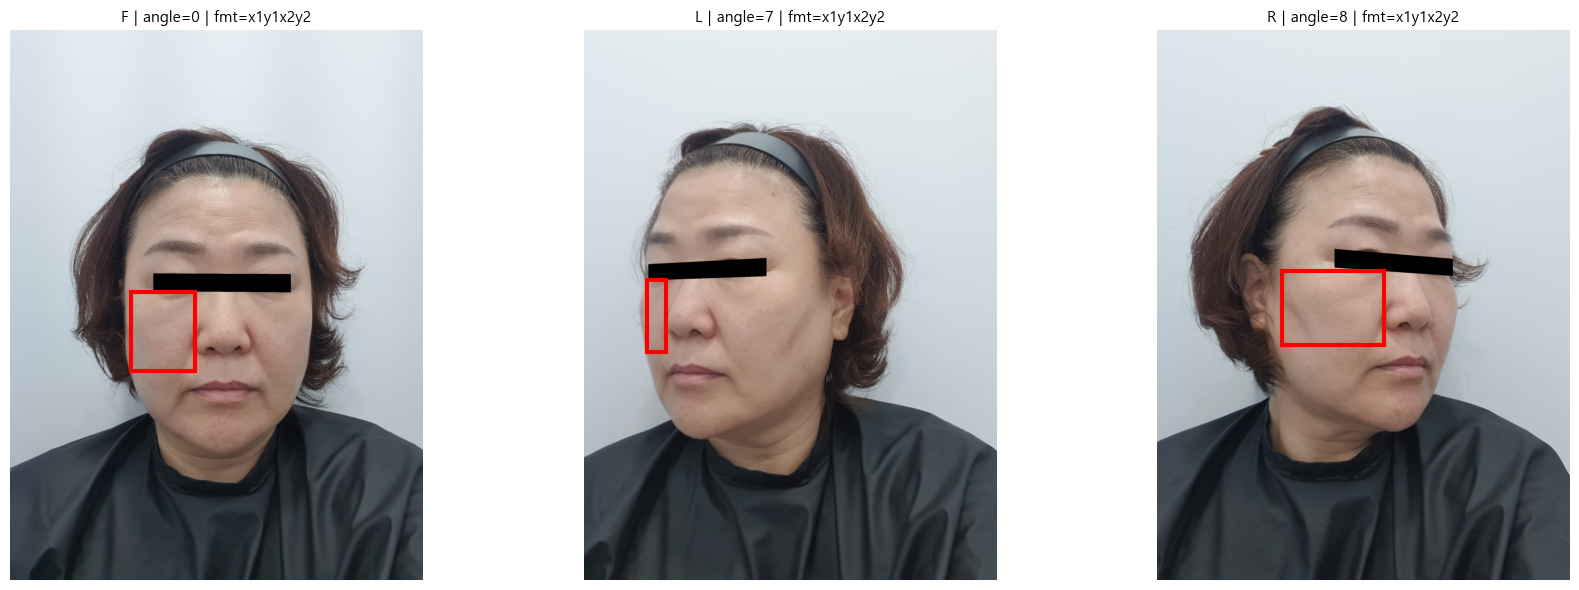

In [1]:

import os, json
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# ============================================================
# ✅ 공통 설정 (Subject 기준 오른쪽 볼 = l_cheek)
# ✅ BBOX_FORMAT = "x1y1x2y2" (사용자 확정)
# ============================================================

BASE = r"D:\PyProject\datasets\skinAI\korea_skin_data\model_and_data\docker_image\skin_dataset\data_and_model\dataset"
VERSION = "03"
ANGLES = ["F", "L", "R"]

BBOX_FORMAT = "x1y1x2y2"  # ✅ 확정: [x1,y1,x2,y2]
RIGHT_CHEEK_KEY_PORE = "l_cheek_pore"           # ✅ Subject Right Cheek
RIGHT_CHEEK_KEY_PIG  = "l_cheek_pigmentation"  # ✅ Subject Right Cheek

# ------------------------------------------------------------
# 유틸: 파일 찾기 / bbox 변환 / clamp
# ------------------------------------------------------------
def find_image_file(img_dir, folder, version, angle):
    candidates = [
        f"{folder}_{version}_{angle}_01.jpg",
        f"{folder}_{version}_{angle}.jpg",
        f"{folder}_{version}_{angle}_01.png",
        f"{folder}_{version}_{angle}.png",
    ]
    for name in candidates:
        p = os.path.join(img_dir, name)
        if os.path.exists(p):
            return p
    return None

def clamp_xywh(x, y, w, h, W, H):
    x = max(0, min(x, W - 1))
    y = max(0, min(y, H - 1))
    w = max(1, min(w, W - x))
    h = max(1, min(h, H - y))
    return x, y, w, h

def bbox_to_xywh(bbox, fmt, W, H):
    if not (isinstance(bbox, (list, tuple)) and len(bbox) == 4):
        return None

    a, b, c, d = map(int, bbox)

    if fmt == "x1y1x2y2":
        x1, y1, x2, y2 = a, b, c, d
        x, y = x1, y1
        w, h = x2 - x1, y2 - y1
    elif fmt == "xywh":
        x, y, w, h = a, b, c, d
    else:
        raise ValueError("fmt must be 'x1y1x2y2' or 'xywh'")

    return clamp_xywh(x, y, w, h, W, H)

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def get_bbox_and_angle(data):
    bbox = data.get("images", {}).get("bbox", None)
    angle_code = data.get("images", {}).get("angle", None)
    return bbox, angle_code

# ============================================================
# (1) + (2) 단일 샘플: bbox 시각화 + 파일 정보 출력
# ============================================================
def visualize_subject_right_cheek_bbox(folder="0001", label_suffix="05", version=VERSION, angles=ANGLES):
    img_dir = os.path.join(BASE, "img", version, folder)
    lbl_dir = os.path.join(BASE, "label", version, folder)

    fig, axes = plt.subplots(1, len(angles), figsize=(6*len(angles), 6))
    if len(angles) == 1:
        axes = [axes]

    for ax, A in zip(axes, angles):
        json_path = os.path.join(lbl_dir, f"{folder}_{version}_{A}_{label_suffix}.json")
        img_path  = find_image_file(img_dir, folder, version, A)

        if not os.path.exists(json_path):
            ax.set_title(f"{A} | JSON not found")
            ax.axis("off")
            continue
        if img_path is None:
            ax.set_title(f"{A} | image not found")
            ax.axis("off")
            continue

        data = load_json(json_path)
        bbox, angle_code = get_bbox_and_angle(data)

        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        box = bbox_to_xywh(bbox, BBOX_FORMAT, W, H)

        ax.imshow(img)
        ax.axis("off")

        # ---- (2) 단일 파일 정보 출력 (요청: 충분히, 기존과 동급)
        print(f"[{A}] json={json_path}")
        print(f"[{A}] img ={img_path}")
        print(f"[{A}] img_size=(W={W}, H={H}) | angle_code={angle_code}")
        print(f"[{A}] raw_bbox={bbox} | bbox_format={BBOX_FORMAT}")

        ann = data.get("annotations", {})
        pore = ann.get(RIGHT_CHEEK_KEY_PORE)
        pig  = ann.get(RIGHT_CHEEK_KEY_PIG)
        print(f"[{A}] Subject Right Cheek labels: pore(l_cheek_pore)={pore} | pig(l_cheek_pigmentation)={pig}")

        if box is None:
            ax.set_title(f"{A} | angle={angle_code} | bbox=None", fontsize=11)
            print(f"[{A}] -> bbox_to_xywh: None\n")
            continue

        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.set_title(f"{A} | angle={angle_code} | fmt={BBOX_FORMAT}", fontsize=11)

        print(f"[{A}] -> xywh={(x, y, w, h)} (converted)\n")

    plt.tight_layout()
    plt.show()

# ============================================================
# (3) 전체 분포: Subject Right Cheek(l_cheek_*) 통계 + 그래프
# ============================================================
def scan_subject_right_cheek_distribution(
    label_dir=None,
    version=VERSION,
    angles=ANGLES,
    folder_range=range(1, 1101),
    label_suffix="05",
    pore_key=RIGHT_CHEEK_KEY_PORE,
    pig_key=RIGHT_CHEEK_KEY_PIG
):
    if label_dir is None:
        label_dir = os.path.join(BASE, "label", version)

    counters = {
        "pore": Counter(),
        "pig": Counter(),
    }
    missing = {
        "file": 0,
        "pore": 0,
        "pig": 0,
    }

    for folder in folder_range:
        folder_name = f"{folder:04d}"
        for A in angles:
            path = os.path.join(label_dir, folder_name, f"{folder_name}_{version}_{A}_{label_suffix}.json")

            if not os.path.exists(path):
                missing["file"] += 1
                continue

            data = load_json(path)
            ann = data.get("annotations", {})

            pore = ann.get(pore_key)
            pig  = ann.get(pig_key)

            if pore is None:
                missing["pore"] += 1
            else:
                counters["pore"][pore] += 1

            if pig is None:
                missing["pig"] += 1
            else:
                counters["pig"][pig] += 1

    # ---- 출력 (요청: 충분히, 기존 수준 유지)
    def print_block(title, counter, missing_label, missing_file):
        print("="*70)
        print(title)
        total = sum(counter.values())
        print("Valid labels :", total)
        print("Missing label:", missing_label)
        print("Missing file :", missing_file)
        print("-"*70)
        for cls in sorted(counter):
            print(f"Class {cls} : {counter[cls]:5d} ({(counter[cls]/total*100 if total>0 else 0):6.2f}%)")
        print("="*70)
        return total

    total_pore = print_block("[Subject Right Cheek Pore Distribution]", counters["pore"], missing["pore"], missing["file"])
    total_pig  = print_block("[Subject Right Cheek Pigmentation Distribution]", counters["pig"], missing["pig"], missing["file"])

    # ---- 그래프 (기존과 동일한 수준의 정보)
    if total_pore > 0 and total_pig > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Pore
        pore_classes = sorted(counters["pore"].keys())
        pore_counts  = [counters["pore"][c] for c in pore_classes]
        pore_pct     = [cnt/total_pore*100 for cnt in pore_counts]

        bars1 = axes[0].bar(pore_classes, pore_counts)
        axes[0].set_title("Right Cheek Pore Distribution (Subject 기준, l_cheek_pore)")
        axes[0].set_xlabel("Grade")
        axes[0].set_ylabel("Count")
        for bar, pct in zip(bars1, pore_pct):
            h = bar.get_height()
            axes[0].text(bar.get_x()+bar.get_width()/2, h, f"{pct:.1f}%", ha="center", va="bottom")

        # Pig
        pig_classes = sorted(counters["pig"].keys())
        pig_counts  = [counters["pig"][c] for c in pig_classes]
        pig_pct     = [cnt/total_pig*100 for cnt in pig_counts]

        bars2 = axes[1].bar(pig_classes, pig_counts)
        axes[1].set_title("Right Cheek Pigmentation Distribution (Subject 기준, l_cheek_pigmentation)")
        axes[1].set_xlabel("Grade")
        axes[1].set_ylabel("Count")
        for bar, pct in zip(bars2, pig_pct):
            h = bar.get_height()
            axes[1].text(bar.get_x()+bar.get_width()/2, h, f"{pct:.1f}%", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()
        
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'   # Windows 기본 한글 폰트
mpl.rcParams['axes.unicode_minus'] = False      # 마이너스 깨짐 방지
# ============================================================
# ✅ 이미지 확인
# ============================================================
# (1) + (2) 단일 샘플 bbox 시각화 + 파일 정보
visualize_subject_right_cheek_bbox(folder="0001", label_suffix="05")

[Subject Right Cheek Pore Distribution]
Valid labels : 3216
Missing label: 0
Missing file : 84
----------------------------------------------------------------------
Class 0 :    84 (  2.61%)
Class 1 :   573 ( 17.82%)
Class 2 :  1935 ( 60.17%)
Class 3 :   414 ( 12.87%)
Class 4 :   174 (  5.41%)
Class 5 :    36 (  1.12%)
[Subject Right Cheek Pigmentation Distribution]
Valid labels : 3216
Missing label: 0
Missing file : 84
----------------------------------------------------------------------
Class 0 :   108 (  3.36%)
Class 1 :   921 ( 28.64%)
Class 2 :   864 ( 26.87%)
Class 3 :   855 ( 26.59%)
Class 4 :   339 ( 10.54%)
Class 5 :   129 (  4.01%)


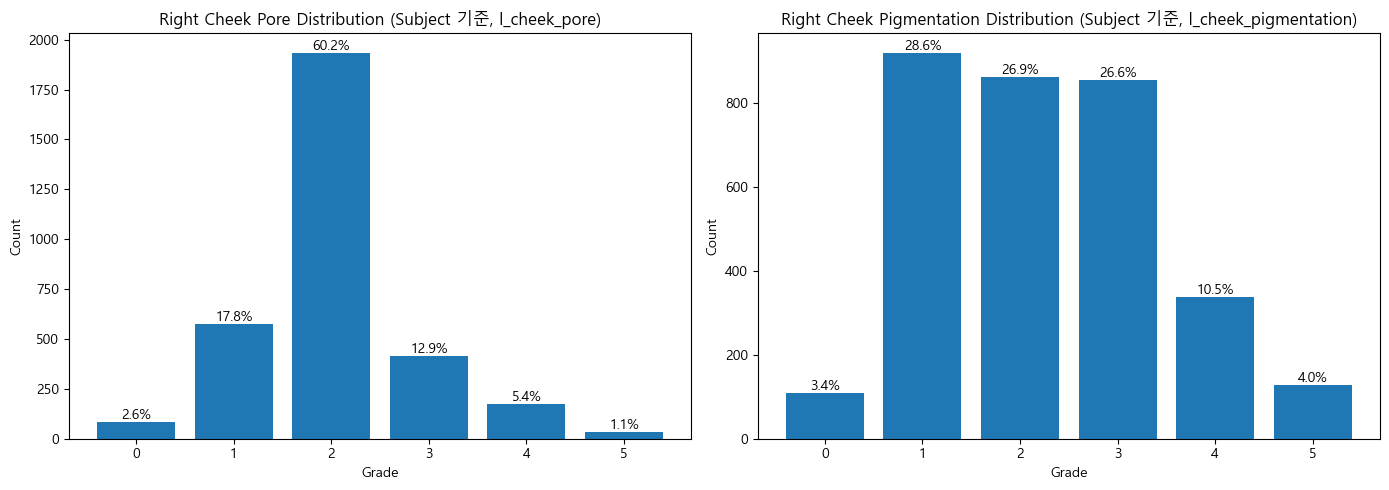

In [3]:
# ============================================================
# ✅ 전체 분포 확인
# ============================================================
# (1) + (2) 단일 샘플 bbox 시각화 + 파일 정보
# visualize_subject_right_cheek_bbox(folder="0001", label_suffix="05")

# (3) 전체 분포
scan_subject_right_cheek_distribution(label_suffix="05")

### 1.2 데이터 전처리(증강 포함)

In [5]:
# ============================================================
# AUGMENT FROM EXISTING CROP FOLDERS ✅ (복붙용, 가장 안전)
# - records 없어도 됨
# - WORK_DIR 아래 기존 crop 폴더를 스캔해서 증강 이미지 생성
# - 결과: *_AUG 폴더에 저장 + 생성 개수/분포 출력
# ============================================================

import os, re, random
import numpy as np
from glob import glob
from collections import Counter
from PIL import Image
from torchvision import transforms

VERSION  = "03"
WORK_DIR = r"D:\PyProject\AIFFEL_AI\skin_analysis"
UPSCALE_TO = (224, 224)

# 폴더
CROP_LEFT  = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}")
CROP_RIGHT = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}")
AUG_LEFT   = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}_AUG")
AUG_RIGHT  = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}_AUG")
os.makedirs(AUG_LEFT, exist_ok=True)
os.makedirs(AUG_RIGHT, exist_ok=True)

# resample
try:
    RESAMPLE = Image.Resampling.BILINEAR
except Exception:
    RESAMPLE = Image.BILINEAR

# crop 파일명에서 label/angle/letter 추출
# 예: 0001_03_angle0_F_LEFTcheek_pore2_crop.jpg
pat_crop = re.compile(
    r"(?P<folder>\d{4})_" + re.escape(VERSION) +
    r"_angle(?P<angle>\d+)_(?P<A>[FLR])_(?P<side>LEFTcheek|RIGHTcheek)_pore(?P<y>[0-4])_crop\.jpg$"
)

def scan_crop_files(crop_root):
    files = glob(os.path.join(crop_root, "*", "*.jpg"))
    recs = []
    bad = 0
    for p in files:
        base = os.path.basename(p)
        m = pat_crop.match(base)
        if not m:
            bad += 1
            continue
        d = m.groupdict()
        recs.append({
            "folder": d["folder"],
            "angle": int(d["angle"]),
            "A": d["A"],
            "side": d["side"],
            "y": int(d["y"]),
            "crop_path": p
        })
    return recs, bad, len(files)

# 증강 함수
def apply_aug(img: Image.Image):
    aug_type = random.choice(["color","geometry","noise","combo"])

    if aug_type in ("color","combo"):
        img = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        )(img)

    if aug_type in ("geometry","combo"):
        if random.random() > 0.5:
            img = transforms.functional.hflip(img)
        if random.random() > 0.5:
            img = transforms.functional.vflip(img)
        img = transforms.functional.rotate(img, angle=random.uniform(-10, 10))

    if aug_type in ("noise","combo"):
        arr = np.array(img).astype(np.float32)/255.0
        noise = np.random.normal(0, 0.05, arr.shape).astype(np.float32)
        arr = np.clip(arr+noise, 0, 1)
        img = Image.fromarray((arr*255).astype("uint8"))

    return img

# 라벨 분포 기반 자동 증강 횟수
def build_auto_aug_times(label_counter, target_ratio=1.0, max_cap=25):
    max_count = max(label_counter.values()) if label_counter else 0
    times = {}
    for c in sorted(label_counter.keys()):
        cnt = label_counter[c]
        target = max_count * float(target_ratio)
        t = int(np.ceil(target/cnt) - 1)
        t = max(0, min(t, max_cap))
        times[c] = t
    return times

def make_aug(crop_recs, aug_root, seed=42):
    random.seed(seed); np.random.seed(seed)
    dist = Counter(r["y"] for r in crop_recs)
    times_by_class = build_auto_aug_times(dist, target_ratio=1.0, max_cap=25)

    print("[DIST] crop label:", dict(dist))
    print("[AUG TIMES]:", times_by_class)

    saved = 0
    for r in crop_recs:
        y = r["y"]
        times = times_by_class.get(y, 0)
        if times <= 0:
            continue

        base = Image.open(r["crop_path"]).convert("RGB").resize(UPSCALE_TO, RESAMPLE)
        out_sub = os.path.join(aug_root, r["folder"])
        os.makedirs(out_sub, exist_ok=True)

        for k in range(times):
            aug_img = apply_aug(base).resize(UPSCALE_TO, RESAMPLE)
            out_name = f"{r['folder']}_{VERSION}_angle{r['angle']}_{r['A']}_{r['side']}_pore{y}_aug{k:03d}.jpg"
            out_path = os.path.join(out_sub, out_name)
            aug_img.save(out_path)
            saved += 1

    return saved, times_by_class

# ---- 실행: LEFT/RIGHT ----
left_recs, badL, totL = scan_crop_files(CROP_LEFT)
right_recs, badR, totR = scan_crop_files(CROP_RIGHT)

print("=== SCAN CROP ===")
print(f"LEFT : files={totL}, parsed={len(left_recs)}, bad_name={badL}, dir={CROP_LEFT}")
print(f"RIGHT: files={totR}, parsed={len(right_recs)}, bad_name={badR}, dir={CROP_RIGHT}")

if len(left_recs)==0 or len(right_recs)==0:
    raise RuntimeError("크롭 폴더는 있는데 파싱된 crop 레코드가 0입니다. 파일명 규칙이 pat_crop와 다른지 확인이 필요합니다.")

print("\n=== GENERATE AUG ===")
nL, timesL = make_aug(left_recs, AUG_LEFT, seed=123)
nR, timesR = make_aug(right_recs, AUG_RIGHT, seed=456)

print("\n" + "="*80)
print("[AUG DONE]")
print(f"- LEFT  aug_saved={nL} | AUG_DIR={AUG_LEFT}")
print(f"- RIGHT aug_saved={nR} | AUG_DIR={AUG_RIGHT}")
print("="*80)

# ---- 증강 폴더 실제 파일 수 확인 ----
def count_aug(root):
    return len(glob(os.path.join(root, "*", "*.jpg"))) if os.path.isdir(root) else 0

print(f"[VERIFY] AUG LEFT  files: {count_aug(AUG_LEFT)}")
print(f"[VERIFY] AUG RIGHT files: {count_aug(AUG_RIGHT)}")

D:\anaconda3\envs\skin_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== SCAN CROP ===
LEFT : files=2144, parsed=2144, bad_name=0, dir=D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03
RIGHT: files=2144, parsed=2144, bad_name=0, dir=D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03

=== GENERATE AUG ===
[DIST] crop label: {2: 1302, 1: 366, 4: 144, 3: 276, 0: 56}
[AUG TIMES]: {0: 23, 1: 3, 2: 0, 3: 4, 4: 9}
[DIST] crop label: {2: 1290, 0: 56, 4: 140, 1: 382, 3: 276}
[AUG TIMES]: {0: 23, 1: 3, 2: 0, 3: 4, 4: 9}

[AUG DONE]
- LEFT  aug_saved=4786 | AUG_DIR=D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03_AUG
- RIGHT aug_saved=4798 | AUG_DIR=D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03_AUG
[VERIFY] AUG LEFT  files: 4786
[VERIFY] AUG RIGHT files: 4798


=== PATH CHECK ===
CROP_LEFT : D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03 | exists: True | files: 2144 | bad: 0
CROP_RIGHT: D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03 | exists: True | files: 2144 | bad: 0
AUG_LEFT  : D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03_AUG | exists: True | files: 4786 | bad: 0
AUG_RIGHT : D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03_AUG | exists: True | files: 4798 | bad: 0

[LEFT  CROP] total=2144
  - Class 0:     56 (  2.61%)
  - Class 1:    366 ( 17.07%)
  - Class 2:   1302 ( 60.73%)
  - Class 3:    276 ( 12.87%)
  - Class 4:    144 (  6.72%)

[LEFT  AUG] total=4786
  - Class 0:   1288 ( 26.91%)
  - Class 1:   1098 ( 22.94%)
  - Class 2:      0 (  0.00%)
  - Class 3:   1104 ( 23.07%)
  - Class 4:   1296 ( 27.08%)

[LEFT  TOTAL] total=6930
  - Class 0:   1344 ( 19.39%)
  - Class 1:   1464 ( 21.13%)
  - Class 2:   1302 ( 18.79%)
  - Class 3:   1380 ( 19.91%)


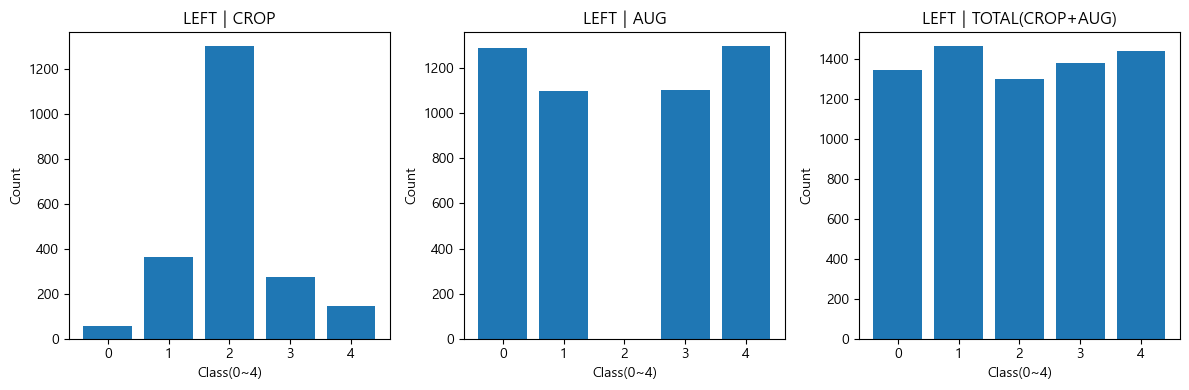


[RIGHT CROP] total=2144
  - Class 0:     56 (  2.61%)
  - Class 1:    382 ( 17.82%)
  - Class 2:   1290 ( 60.17%)
  - Class 3:    276 ( 12.87%)
  - Class 4:    140 (  6.53%)

[RIGHT AUG] total=4798
  - Class 0:   1288 ( 26.84%)
  - Class 1:   1146 ( 23.88%)
  - Class 2:      0 (  0.00%)
  - Class 3:   1104 ( 23.01%)
  - Class 4:   1260 ( 26.26%)

[RIGHT TOTAL] total=6942
  - Class 0:   1344 ( 19.36%)
  - Class 1:   1528 ( 22.01%)
  - Class 2:   1290 ( 18.58%)
  - Class 3:   1380 ( 19.88%)
  - Class 4:   1400 ( 20.17%)


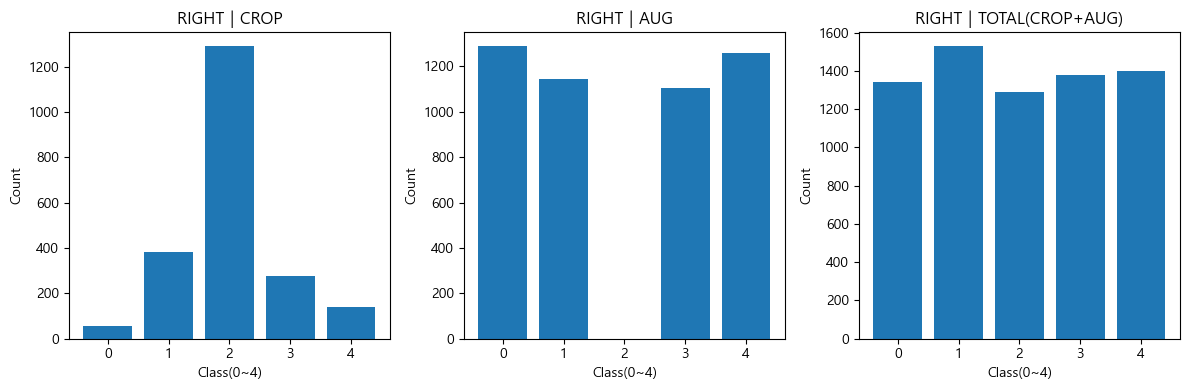


[ALL   CROP (L+R)] total=4288
  - Class 0:    112 (  2.61%)
  - Class 1:    748 ( 17.44%)
  - Class 2:   2592 ( 60.45%)
  - Class 3:    552 ( 12.87%)
  - Class 4:    284 (  6.62%)

[ALL   AUG  (L+R)] total=9584
  - Class 0:   2576 ( 26.88%)
  - Class 1:   2244 ( 23.41%)
  - Class 2:      0 (  0.00%)
  - Class 3:   2208 ( 23.04%)
  - Class 4:   2556 ( 26.67%)

[ALL   TOTAL(CROP+AUG, L+R)] total=13872
  - Class 0:   2688 ( 19.38%)
  - Class 1:   2992 ( 21.57%)
  - Class 2:   2592 ( 18.69%)
  - Class 3:   2760 ( 19.90%)
  - Class 4:   2840 ( 20.47%)


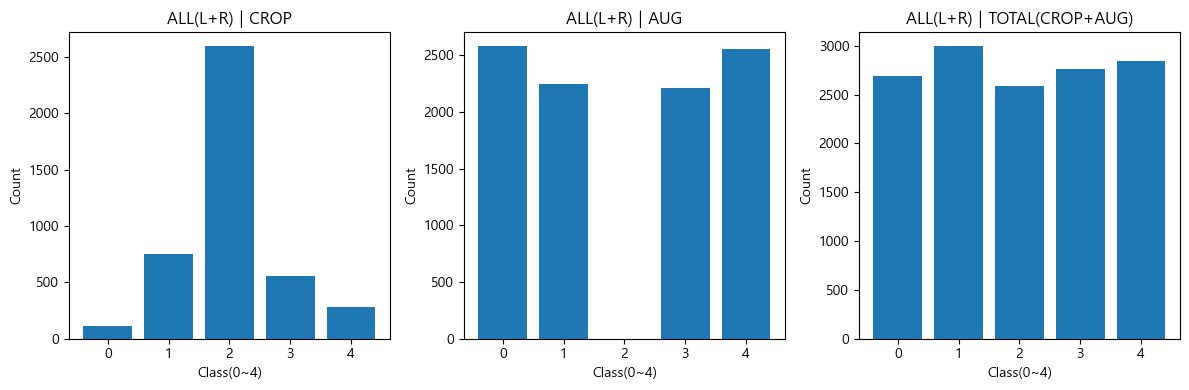

In [6]:
# ============================================================
# DIST CHECK ✅ CROP vs AUG vs TOTAL (LEFT/RIGHT + COMBINED)
# - records 없이도 동작: 폴더의 jpg 파일명에서 pore{y} 파싱
# - 출력: (1) CROP 분포, (2) AUG 분포, (3) TOTAL 분포
#         각각 LEFT/RIGHT/COMBINED
# ============================================================

import os, re
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt

VERSION  = "03"
WORK_DIR = r"D:\PyProject\AIFFEL_AI\skin_analysis"

CROP_LEFT  = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}")
CROP_RIGHT = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}")
AUG_LEFT   = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}_AUG")
AUG_RIGHT  = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}_AUG")

# 파일명에서 label(y) 뽑기: ..._pore{y}_crop.jpg / ..._pore{y}_aug000.jpg
pat_y = re.compile(r"_pore(?P<y>[0-4])_(?:crop|aug\d{3})\.jpg$")

def scan_label_dist(root_dir):
    """
    root_dir/*/*.jpg 스캔
    return: dist(Counter), total_files, bad_files
    """
    dist = Counter()
    if not os.path.isdir(root_dir):
        return dist, 0, 0

    files = glob(os.path.join(root_dir, "*", "*.jpg"))
    bad = 0
    for p in files:
        base = os.path.basename(p)
        m = pat_y.search(base)
        if not m:
            bad += 1
            continue
        dist[int(m.group("y"))] += 1
    return dist, len(files), bad

def add_counter(a, b):
    c = Counter(a)
    c.update(b)
    return c

def counter_to_list(c, n_cls=5):
    return [c.get(i, 0) for i in range(n_cls)]

def print_dist(title, dist):
    total = sum(dist.values())
    print(f"\n[{title}] total={total}")
    for k in range(5):
        v = dist.get(k, 0)
        pct = (v/total*100) if total else 0
        print(f"  - Class {k}: {v:6d} ({pct:6.2f}%)")

def plot_triplet(d_crop, d_aug, d_total, tag):
    x = list(range(5))
    crop = counter_to_list(d_crop)
    aug  = counter_to_list(d_aug)
    tot  = counter_to_list(d_total)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.bar(x, crop)
    plt.title(f"{tag} | CROP")
    plt.xlabel("Class(0~4)"); plt.ylabel("Count"); plt.xticks(x)

    plt.subplot(1,3,2)
    plt.bar(x, aug)
    plt.title(f"{tag} | AUG")
    plt.xlabel("Class(0~4)"); plt.ylabel("Count"); plt.xticks(x)

    plt.subplot(1,3,3)
    plt.bar(x, tot)
    plt.title(f"{tag} | TOTAL(CROP+AUG)")
    plt.xlabel("Class(0~4)"); plt.ylabel("Count"); plt.xticks(x)

    plt.tight_layout()
    plt.show()

# -------------------------
# 1) LEFT/RIGHT 각각 스캔
# -------------------------
crop_L, nCL, badCL = scan_label_dist(CROP_LEFT)
crop_R, nCR, badCR = scan_label_dist(CROP_RIGHT)
aug_L,  nAL, badAL = scan_label_dist(AUG_LEFT)
aug_R,  nAR, badAR = scan_label_dist(AUG_RIGHT)

tot_L = add_counter(crop_L, aug_L)
tot_R = add_counter(crop_R, aug_R)

# -------------------------
# 2) COMBINED(LEFT+RIGHT)
# -------------------------
crop_ALL = add_counter(crop_L, crop_R)
aug_ALL  = add_counter(aug_L,  aug_R)
tot_ALL  = add_counter(tot_L,  tot_R)

# -------------------------
# 3) 출력(파일 파싱 상태도 같이)
# -------------------------
print("=== PATH CHECK ===")
print("CROP_LEFT :", CROP_LEFT,  "| exists:", os.path.isdir(CROP_LEFT),  "| files:", nCL, "| bad:", badCL)
print("CROP_RIGHT:", CROP_RIGHT, "| exists:", os.path.isdir(CROP_RIGHT), "| files:", nCR, "| bad:", badCR)
print("AUG_LEFT  :", AUG_LEFT,   "| exists:", os.path.isdir(AUG_LEFT),   "| files:", nAL, "| bad:", badAL)
print("AUG_RIGHT :", AUG_RIGHT,  "| exists:", os.path.isdir(AUG_RIGHT),  "| files:", nAR, "| bad:", badAR)

# LEFT
print_dist("LEFT  CROP", crop_L)
print_dist("LEFT  AUG",  aug_L)
print_dist("LEFT  TOTAL", tot_L)
plot_triplet(crop_L, aug_L, tot_L, tag="LEFT")

# RIGHT
print_dist("RIGHT CROP", crop_R)
print_dist("RIGHT AUG",  aug_R)
print_dist("RIGHT TOTAL", tot_R)
plot_triplet(crop_R, aug_R, tot_R, tag="RIGHT")

# COMBINED
print_dist("ALL   CROP (L+R)", crop_ALL)
print_dist("ALL   AUG  (L+R)", aug_ALL)
print_dist("ALL   TOTAL(CROP+AUG, L+R)", tot_ALL)
plot_triplet(crop_ALL, aug_ALL, tot_ALL, tag="ALL(L+R)")

### 2. Dataset & DataLoader

In [10]:
# ============================================================
# 0) BUILD DATALOADERS ✅ (AUG->TRAIN only / VAL&TEST->CROP only)
# - Folder(피사체) 단위 split (누수 방지)
# - num_workers=0
# ============================================================

import os, re, random
from glob import glob
from collections import defaultdict, Counter

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# -----------------------
# PATH
# -----------------------
VERSION  = "03"
WORK_DIR = r"D:\PyProject\AIFFEL_AI\skin_analysis"

CROP_LEFT  = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}")
CROP_RIGHT = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}")
AUG_LEFT   = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}_AUG")
AUG_RIGHT  = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}_AUG")

# -----------------------
# filename parse
# -----------------------
# ..._pore{y}_crop.jpg / ..._pore{y}_aug000.jpg
pat = re.compile(r"(?P<folder>\d{4})_.*_pore(?P<y>[0-4])_(?P<tag>crop|aug\d{3})\.jpg$")

def scan_items(root_dir):
    files = glob(os.path.join(root_dir, "*", "*.jpg")) if os.path.isdir(root_dir) else []
    items = []
    bad = 0
    for p in files:
        base = os.path.basename(p)
        m = pat.match(base)
        if not m:
            bad += 1
            continue
        items.append({
            "path": p,
            "folder": m.group("folder"),
            "y": int(m.group("y")),
            "is_aug": m.group("tag").startswith("aug"),
        })
    return items, len(files), bad

# -----------------------
# scan
# -----------------------
crop_left,  n1, b1 = scan_items(CROP_LEFT)
crop_right, n2, b2 = scan_items(CROP_RIGHT)
aug_left,   n3, b3 = scan_items(AUG_LEFT)
aug_right,  n4, b4 = scan_items(AUG_RIGHT)

crop_items = crop_left + crop_right
aug_items  = aug_left  + aug_right

print("=== SCAN ===")
print(f"CROP_LEFT : files={n1}, parsed={len(crop_left)}, bad={b1}")
print(f"CROP_RIGHT: files={n2}, parsed={len(crop_right)}, bad={b2}")
print(f"AUG_LEFT  : files={n3}, parsed={len(aug_left)}, bad={b3}")
print(f"AUG_RIGHT : files={n4}, parsed={len(aug_right)}, bad={b4}")
print(f"TOTAL CROP items={len(crop_items)} | TOTAL AUG items={len(aug_items)}")

if len(crop_items) == 0:
    raise RuntimeError("CROP 데이터가 0개입니다. crop 폴더 경로/파일을 확인하세요.")
if len(aug_items) == 0:
    print("⚠️ AUG 데이터가 0개입니다. (증강 폴더가 비었거나 파일명 규칙이 다를 수 있음)")

# -----------------------
# folder-group split (CROP만으로 폴더 나눔)
# -----------------------
def split_folders(crop_items, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)

    folder2items = defaultdict(list)
    for it in crop_items:
        folder2items[it["folder"]].append(it)

    folders = list(folder2items.keys())
    random.shuffle(folders)

    n = len(folders)
    n_test = max(1, int(n * test_ratio))
    n_val  = max(1, int(n * val_ratio))

    test_folders = set(folders[:n_test])
    val_folders  = set(folders[n_test:n_test+n_val])
    train_folders= set(folders[n_test+n_val:])

    train_crop = [it for f in train_folders for it in folder2items[f]]
    val_crop   = [it for f in val_folders  for it in folder2items[f]]
    test_crop  = [it for f in test_folders for it in folder2items[f]]

    return train_folders, val_folders, test_folders, train_crop, val_crop, test_crop

train_folders, val_folders, test_folders, train_crop, val_crop, test_crop = split_folders(
    crop_items, val_ratio=0.15, test_ratio=0.15, seed=42
)

# ✅ AUG는 TRAIN 폴더에 해당하는 것만 TRAIN에 합침 (누수 방지)
aug_train = [it for it in aug_items if it["folder"] in train_folders]
train_items = train_crop + aug_train

print("\n=== SPLIT ===")
print(f"folders: train={len(train_folders)}, val={len(val_folders)}, test={len(test_folders)}")
print(f"items  : train_crop={len(train_crop)}, aug_train={len(aug_train)} => train_total={len(train_items)}")
print(f"         val_crop={len(val_crop)} | test_crop={len(test_crop)}")

def dist(items):
    c = Counter([it["y"] for it in items])
    tot = sum(c.values())
    return {k: f"{v} ({(v/tot*100 if tot else 0):.1f}%)" for k,v in sorted(c.items())}

print("\n[DIST] train_total (CROP+AUG):", dist(train_items))
print("[DIST] val_crop (CROP only) :", dist(val_crop))
print("[DIST] test_crop(CROP only) :", dist(test_crop))

# -----------------------
# Dataset / DataLoader
# -----------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class PoreDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        p = self.items[idx]["path"]
        y = self.items[idx]["y"]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

train_ds = PoreDataset(train_items, transform)
val_ds   = PoreDataset(val_crop, transform)
test_ds  = PoreDataset(test_crop, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

print("\n✅ DONE: train_loader / val_loader / test_loader ready (num_workers=0)")

=== SCAN ===
CROP_LEFT : files=2144, parsed=2144, bad=0
CROP_RIGHT: files=2144, parsed=2144, bad=0
AUG_LEFT  : files=4786, parsed=4786, bad=0
AUG_RIGHT : files=4798, parsed=4798, bad=0
TOTAL CROP items=4288 | TOTAL AUG items=9584

=== SPLIT ===
folders: train=752, val=160, test=160
items  : train_crop=3008, aug_train=6444 => train_total=9452
         val_crop=640 | test_crop=640

[DIST] train_total (CROP+AUG): {0: '1488 (15.7%)', 1: '1992 (21.1%)', 2: '1832 (19.4%)', 3: '2020 (21.4%)', 4: '2120 (22.4%)'}
[DIST] val_crop (CROP only) : {0: '16 (2.5%)', 1: '152 (23.8%)', 2: '382 (59.7%)', 3: '74 (11.6%)', 4: '16 (2.5%)'}
[DIST] test_crop(CROP only) : {0: '34 (5.3%)', 1: '98 (15.3%)', 2: '378 (59.1%)', 3: '74 (11.6%)', 4: '56 (8.8%)'}

✅ DONE: train_loader / val_loader / test_loader ready (num_workers=0)


### 3. 학습

In [16]:
# ============================================================
# [CELL 0] 필수 확인 + 설정 (num_workers=0 / 증강 포함 학습 / 좌우 통합 확인)
# ============================================================

import os, time, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import models
from torchvision.models import EfficientNet_B3_Weights
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix

# ----------------------------
# ✅ 필수: 로더가 이미 생성되어 있어야 함
# - train_loader / val_loader / test_loader
# ----------------------------
assert "train_loader" in globals() and "val_loader" in globals() and "test_loader" in globals(), \
    "train_loader / val_loader / test_loader 가 없습니다. 먼저 dataloader 생성 셀을 실행하세요."

# ----------------------------
# ✅ (1) num_workers=0 확인
# ----------------------------
assert train_loader.num_workers == 0 and val_loader.num_workers == 0 and test_loader.num_workers == 0, \
    "num_workers가 0이 아닙니다. DataLoader(num_workers=0)로 다시 만드세요."

print(f"[CHECK] num_workers: train={train_loader.num_workers}, val={val_loader.num_workers}, test={test_loader.num_workers}")

# ----------------------------
# ✅ (1) 증강 포함 학습 확인: train_loader 데이터 수(=train_total) 확인
# ----------------------------
print(f"[CHECK] train_dataset size = {len(train_loader.dataset)} (CROP + AUG 포함이어야 함)")
print(f"[CHECK] val_dataset   size = {len(val_loader.dataset)}")
print(f"[CHECK] test_dataset  size = {len(test_loader.dataset)}")

# ----------------------------
# ✅ (1) 좌/우 따라 학습하는 게 아니라 "통합 데이터"임을 확인
# - 현재 PoreDataset은 "items"를 합쳐 넣었고, loader는 단일 train/val/test임.
# - 추가로 샘플 파일 경로에 LEFT/RIGHT가 섞여 있는지 일부 출력
# ----------------------------
def _peek_paths(dataset, n=5):
    # dataset.items 구조를 썼다면 items 접근 가능. 아니면 __getitem__만 가능하므로 try.
    try:
        paths = [dataset.items[i]["path"] for i in range(min(n, len(dataset)))]
    except Exception:
        paths = ["(dataset.items 접근 불가: 내부구조 다름)"]
    return paths

print("\n[PEEK] train sample paths (일부):")
for p in _peek_paths(train_loader.dataset, n=8):
    print(" -", p)

# ----------------------------
# TRAIN CONFIG (요구사항 반영)
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 5           # 0~4
EPOCHS = 100              # ✅ 요구: 100
PATIENCE = 10             # ✅ 요구: 10

# 정칙화/안전장치(요구사항 2)
LR = 3e-4
WEIGHT_DECAY = 3e-4       # AdamW 정칙화
DROPOUT = 0.2             # head dropout
LABEL_SMOOTH = 0.0        # 필요하면 0.05 등으로 조정 가능(지금은 0)
GRAD_CLIP = 1.0           # 그라디언트 클리핑(원치 않으면 None)
AMP = True                # mixed precision

# 스케줄러
T_MAX = 20                # CosineAnnealingLR 주기(원치 않으면 EPOCHS로)

# 저장
SAVE_DIR = "./checkpoints_pore"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n[CONFIG] DEVICE={DEVICE} | EPOCHS={EPOCHS} | PATIENCE={PATIENCE} | LR={LR} | WD={WEIGHT_DECAY} | DROPOUT={DROPOUT}")

[CHECK] num_workers: train=0, val=0, test=0
[CHECK] train_dataset size = 9452 (CROP + AUG 포함이어야 함)
[CHECK] val_dataset   size = 640
[CHECK] test_dataset  size = 640

[PEEK] train sample paths (일부):
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03\1057\1057_03_angle0_F_LEFTcheek_pore2_crop.jpg
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03\1057\1057_03_angle7_L_LEFTcheek_pore2_crop.jpg
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03\1057\1057_03_angle0_F_RIGHTcheek_pore2_crop.jpg
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03\1057\1057_03_angle8_R_RIGHTcheek_pore2_crop.jpg
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03\0554\0554_03_angle0_F_LEFTcheek_pore1_crop.jpg
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_LEFTcheek_pore_v03\0554\0554_03_angle7_L_LEFTcheek_pore1_crop.jpg
 - D:\PyProject\AIFFEL_AI\skin_analysis\crop_subject_RIGHTcheek_pore_v03\0554\0554_0

In [18]:
# ============================================================
# [CELL 1] 공통 유틸: seed / 러닝커브 / 혼동행렬(Blue) / 평가 함수
# ============================================================

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

@torch.no_grad()
def eval_loop(model, loader, mode="ce"):
    """
    mode='ce'    : model(x)->(B,K)
    mode='coral' : model(x)->(B,K-1)
    return: loss_avg, acc_avg, y_true(list), y_pred(list)
    """
    model.eval()
    total_loss, total_correct, n = 0.0, 0.0, 0
    y_true_all, y_pred_all = [], []

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)

        if mode == "ce":
            # CE loss
            loss = F.cross_entropy(out, y, label_smoothing=LABEL_SMOOTH)
            pred = out.argmax(dim=1)

        elif mode == "coral":
            # CORAL loss/pred
            logits = out                         # (B, K-1)
            ord_y  = labels_to_ordinal(y, NUM_CLASSES)  # (B, K-1)
            loss = F.binary_cross_entropy_with_logits(logits, ord_y)
            pred = coral_predict(logits)          # (B,)
        else:
            raise ValueError("mode must be 'ce' or 'coral'")

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_correct += (pred == y).float().sum().item()
        n += bs

        y_true_all.extend(y.detach().cpu().numpy().tolist())
        y_pred_all.extend(pred.detach().cpu().numpy().tolist())

    return total_loss / n, total_correct / n, y_true_all, y_pred_all


def plot_learning_curves(history, title="Learning Curves"):
    """
    history keys:
      - train_loss, val_loss, train_acc, val_acc
      - best_epoch, early_stop_counter_trace(optional)
    """
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    if history.get("best_epoch", None):
        plt.axvline(history["best_epoch"], linestyle="--", label="best_epoch")
    plt.title(f"{title} - Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    # Acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    if history.get("best_epoch", None):
        plt.axvline(history["best_epoch"], linestyle="--", label="best_epoch")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confmat_blue(y_true, y_pred, title="Confusion Matrix (Blue)", class_names=None):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.colorbar()

    if class_names is None:
        class_names = [str(i) for i in range(NUM_CLASSES)]
    plt.xticks(range(NUM_CLASSES), class_names)
    plt.yticks(range(NUM_CLASSES), class_names)

    # 숫자 표기
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return cm, acc

In [20]:
# ============================================================
# [CELL 2] 모델 정의 (공통 backbone) + CORAL 유틸
# ============================================================

# ---------- CORAL utilities ----------
def labels_to_ordinal(y, num_classes=NUM_CLASSES):
    """
    y: (B,) in 0..K-1
    return: (B, K-1) with 1 if y>=k else 0 for k=1..K-1
    """
    B = y.size(0)
    K = num_classes
    th = torch.arange(1, K, device=y.device).view(1, K-1).repeat(B, 1)   # 1..K-1
    y_expand = y.view(B, 1).repeat(1, K-1)
    return (y_expand >= th).float()

@torch.no_grad()
def coral_predict(logits):
    p = torch.sigmoid(logits)
    return (p > 0.5).sum(dim=1).long()

# ---------- Backbones ----------
class EffB3_CE(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        w = EfficientNet_B3_Weights.DEFAULT
        self.backbone = models.efficientnet_b3(weights=w)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)


class EffB3_CORAL(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        w = EfficientNet_B3_Weights.DEFAULT
        self.backbone = models.efficientnet_b3(weights=w)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        # K-1 thresholds
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes - 1)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

In [22]:
# ============================================================
# [CELL 3] 학습 루프 (조기종료/페이션스/정칙화/러닝커브/조건 추적)
# - 요구사항:
#   (2) early stopping + patience=10 + 정칙화 내용 확인
#   (3) epoch마다 early stop counter 진행상황 출력
# ============================================================

def train_with_earlystop(
    mode,                         # "ce" or "coral"
    train_loader, val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    lr=LR, wd=WEIGHT_DECAY,
    tmax=T_MAX,
    grad_clip=GRAD_CLIP,
    amp=AMP,
    ckpt_name="best.pt",
    # ✅ CORAL 요구: 개선될 때마다 혼동행렬 보여주기
    show_cm_on_improve=False,
):
    assert mode in ("ce", "coral")

    # model
    model = EffB3_CE().to(DEVICE) if mode == "ce" else EffB3_CORAL().to(DEVICE)

    # optimizer / scheduler
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sch = CosineAnnealingLR(opt, T_max=tmax, eta_min=1e-6)

    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    # history for learning curves
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "best_epoch": 0,
        "best_val_acc": -1.0,
        "early_stop_counter_trace": [],
    }

    best_path = os.path.join(SAVE_DIR, ckpt_name)
    early_counter = 0

    print("\n" + "="*90)
    print(f"[TRAIN START] mode={mode.upper()} | epochs={epochs} | patience={patience} | lr={lr} | wd={wd} | amp={amp} | grad_clip={grad_clip}")
    print(f"[SAVE] {best_path}")
    print("="*90)

    for ep in range(1, epochs + 1):
        t0 = time.time()
        model.train()

        total_loss, total_correct, n = 0.0, 0.0, 0

        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=amp):
                out = model(x)

                if mode == "ce":
                    loss = F.cross_entropy(out, y, label_smoothing=LABEL_SMOOTH)
                    pred = out.argmax(dim=1)

                else:  # coral
                    logits = out
                    ord_y  = labels_to_ordinal(y, NUM_CLASSES)
                    loss = F.binary_cross_entropy_with_logits(logits, ord_y)
                    pred = coral_predict(logits)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(opt)
            scaler.update()

            bs = y.size(0)
            total_loss += loss.item() * bs
            total_correct += (pred == y).float().sum().item()
            n += bs

        sch.step()

        train_loss = total_loss / n
        train_acc  = total_correct / n

        val_loss, val_acc, yv_true, yv_pred = eval_loop(model, val_loader, mode=mode)

        # --- early stopping logic (val_acc 기준) ---
        improved = val_acc > history["best_val_acc"]
        if improved:
            history["best_val_acc"] = val_acc
            history["best_epoch"] = ep
            early_counter = 0
            torch.save({"epoch": ep, "state_dict": model.state_dict()}, best_path)

            # ✅ CORAL: 개선될 때마다 혼동행렬 보여주기 (요구사항 5)
            if show_cm_on_improve:
                _cm, _acc = plot_confmat_blue(
                    yv_true, yv_pred,
                    title=f"[{mode.upper()}][VAL] Confusion Matrix @ epoch {ep} (improved)",
                    class_names=[f"{i}" for i in range(NUM_CLASSES)]
                )
        else:
            early_counter += 1

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["early_stop_counter_trace"].append(early_counter)

        dt = time.time() - t0

        # (3) epoch마다 early_stop 상태를 명확히 출력
        print(
            f"[{mode.upper()}] ep={ep:03d}/{epochs} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
            f"best={history['best_val_acc']:.4f}@{history['best_epoch']:03d} | "
            f"pat={early_counter:02d}/{patience} | "
            f"time={dt:.1f}s"
            + (" ★" if improved else "")
        )

        if early_counter >= patience:
            print(f"\n[EARLY STOP] no improvement for {patience} epochs. stop at ep={ep}.")
            break

    print("\n" + "-"*90)
    print(f"[TRAIN END] best_val_acc={history['best_val_acc']:.4f} | best_epoch={history['best_epoch']}")
    print(f"[CKPT] {best_path}")
    print("-"*90)

    return model, history, best_path

In [24]:
# ============================================================
# [CELL 4] 테스트(별도) + 혼동행렬(Blue) + 정확도 출력 (요구사항 4)
# ============================================================

@torch.no_grad()
def test_and_report(mode, ckpt_path, test_loader, title_prefix=""):
    assert mode in ("ce", "coral")

    # model load
    model = EffB3_CE().to(DEVICE) if mode == "ce" else EffB3_CORAL().to(DEVICE)
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    test_loss, test_acc, yt_true, yt_pred = eval_loop(model, test_loader, mode=mode)

    print("\n" + "="*90)
    print(f"[{mode.upper()}][TEST] loss={test_loss:.4f} | acc={test_acc:.4f}  ✅(정확도 출력)")
    print("="*90)

    # confusion matrix (blue)
    plot_confmat_blue(
        yt_true, yt_pred,
        title=f"{title_prefix}[{mode.upper()}][TEST] Confusion Matrix (Blues)",
        class_names=[f"{i}" for i in range(NUM_CLASSES)]
    )

    return test_loss, test_acc


[TRAIN START] mode=CE | epochs=100 | patience=10 | lr=0.0003 | wd=0.0003 | amp=True | grad_clip=1.0
[SAVE] ./checkpoints_pore\best_effb3_ce_pore.pt
[CE] ep=001/100 | train_loss=0.9725 train_acc=0.5851 | val_loss=1.1181 val_acc=0.5469 | best=0.5469@001 | pat=00/10 | time=40.4s ★
[CE] ep=002/100 | train_loss=0.5433 train_acc=0.7836 | val_loss=1.2634 val_acc=0.5531 | best=0.5531@002 | pat=00/10 | time=33.1s ★
[CE] ep=003/100 | train_loss=0.3037 train_acc=0.8888 | val_loss=1.6721 val_acc=0.5375 | best=0.5531@002 | pat=01/10 | time=34.4s
[CE] ep=004/100 | train_loss=0.1852 train_acc=0.9337 | val_loss=1.7431 val_acc=0.5703 | best=0.5703@004 | pat=00/10 | time=33.7s ★
[CE] ep=005/100 | train_loss=0.1399 train_acc=0.9519 | val_loss=2.1935 val_acc=0.5953 | best=0.5953@005 | pat=00/10 | time=33.9s ★
[CE] ep=006/100 | train_loss=0.1057 train_acc=0.9629 | val_loss=2.3724 val_acc=0.5531 | best=0.5953@005 | pat=01/10 | time=33.5s
[CE] ep=007/100 | train_loss=0.0796 train_acc=0.9722 | val_loss=2.574

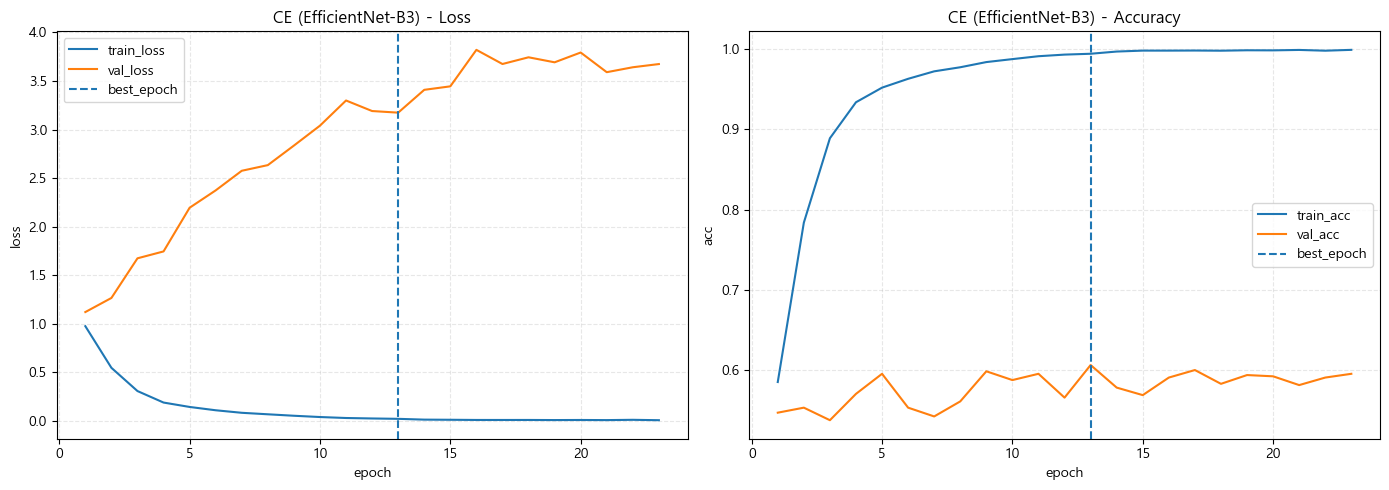


[CE][TEST] loss=3.6253 | acc=0.5547  ✅(정확도 출력)


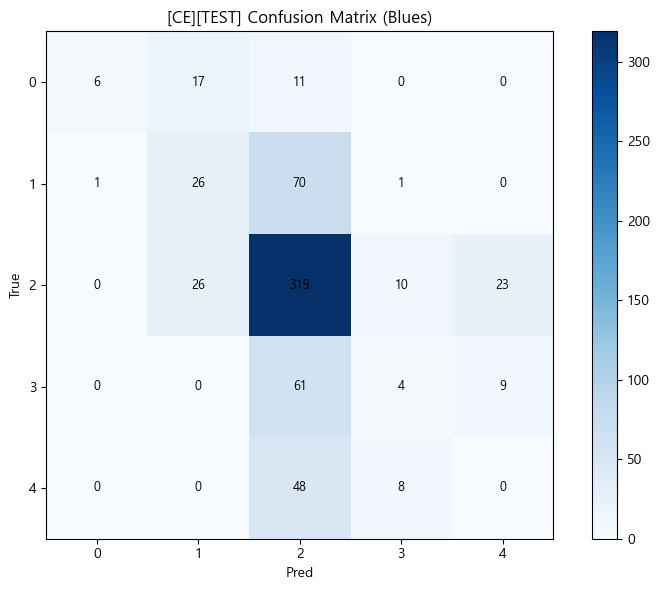

In [26]:
# ============================================================
# [CELL 5] 실행부: CE (요구사항 1~5 충족)
# - CE: 기본 학습 + 러닝커브 + 테스트/혼동행렬
# ============================================================

# ----------------------------
# A) CE 실행
# ----------------------------
ce_model, ce_hist, ce_ckpt = train_with_earlystop(
    mode="ce",
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    lr=LR, wd=WEIGHT_DECAY,
    tmax=T_MAX,
    grad_clip=GRAD_CLIP,
    amp=AMP,
    ckpt_name="best_effb3_ce_pore.pt",
    show_cm_on_improve=False,   # CE는 요구사항에 "개선마다 혼동행렬"이 필수는 아님
)

plot_learning_curves(ce_hist, title="CE (EfficientNet-B3)")

_ = test_and_report("ce", ce_ckpt, test_loader, title_prefix="")


[TRAIN START] mode=CORAL | epochs=100 | patience=10 | lr=0.0003 | wd=0.0003 | amp=True | grad_clip=1.0
[SAVE] ./checkpoints_pore\best_effb3_coral_pore.pt


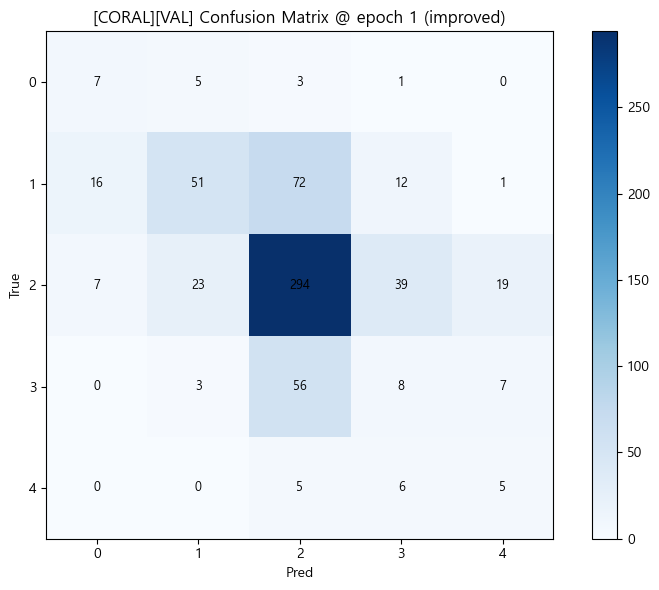

[CORAL] ep=001/100 | train_loss=0.3350 train_acc=0.5353 | val_loss=0.3106 val_acc=0.5703 | best=0.5703@001 | pat=00/10 | time=35.3s ★


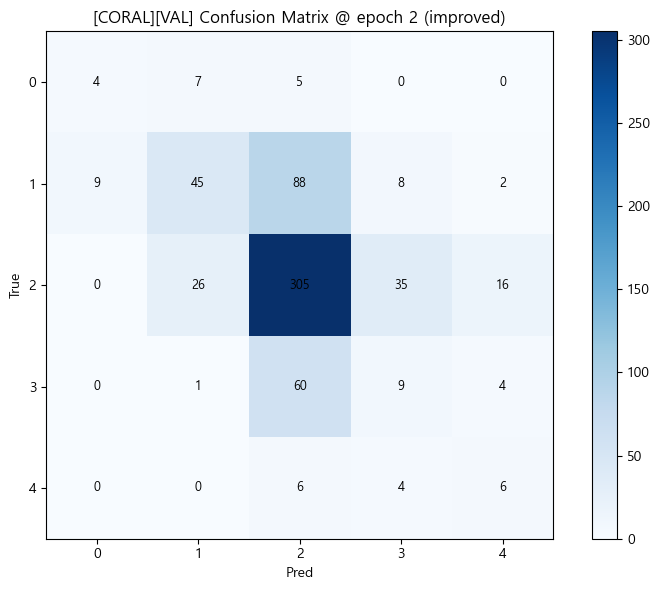

[CORAL] ep=002/100 | train_loss=0.1814 train_acc=0.7443 | val_loss=0.3573 val_acc=0.5766 | best=0.5766@002 | pat=00/10 | time=35.7s ★
[CORAL] ep=003/100 | train_loss=0.1045 train_acc=0.8580 | val_loss=0.4287 val_acc=0.5578 | best=0.5766@002 | pat=01/10 | time=36.5s
[CORAL] ep=004/100 | train_loss=0.0646 train_acc=0.9161 | val_loss=0.5069 val_acc=0.5625 | best=0.5766@002 | pat=02/10 | time=34.4s


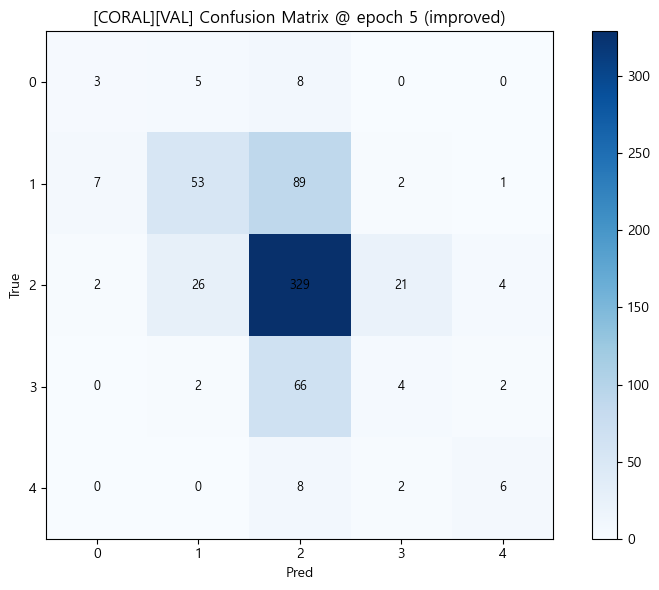

[CORAL] ep=005/100 | train_loss=0.0467 train_acc=0.9382 | val_loss=0.5483 val_acc=0.6172 | best=0.6172@005 | pat=00/10 | time=35.2s ★
[CORAL] ep=006/100 | train_loss=0.0346 train_acc=0.9559 | val_loss=0.5408 val_acc=0.5875 | best=0.6172@005 | pat=01/10 | time=34.3s


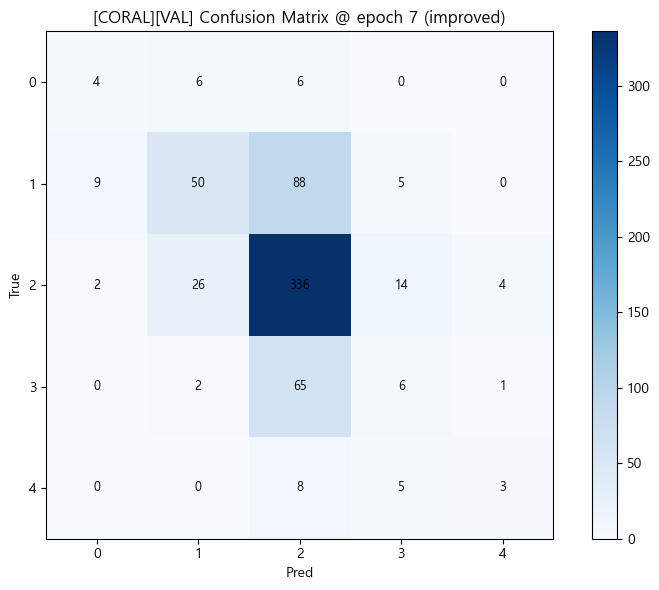

[CORAL] ep=007/100 | train_loss=0.0226 train_acc=0.9707 | val_loss=0.6316 val_acc=0.6234 | best=0.6234@007 | pat=00/10 | time=34.5s ★
[CORAL] ep=008/100 | train_loss=0.0177 train_acc=0.9785 | val_loss=0.5301 val_acc=0.5984 | best=0.6234@007 | pat=01/10 | time=34.7s
[CORAL] ep=009/100 | train_loss=0.0168 train_acc=0.9781 | val_loss=0.6068 val_acc=0.6219 | best=0.6234@007 | pat=02/10 | time=36.1s


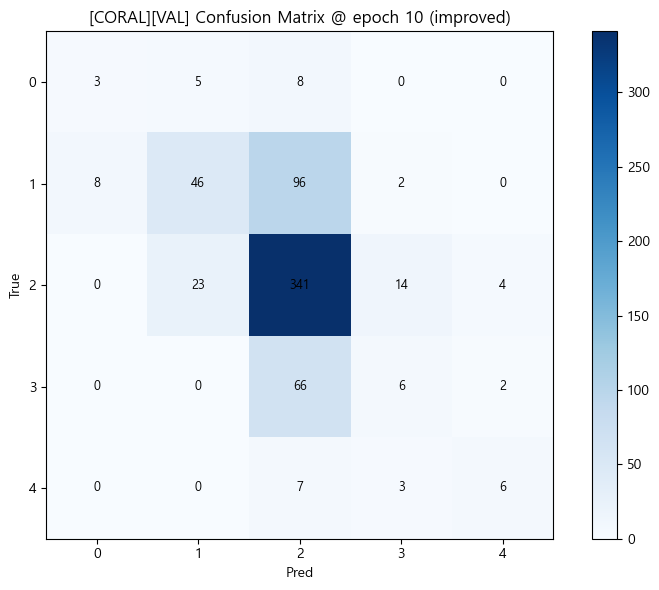

[CORAL] ep=010/100 | train_loss=0.0094 train_acc=0.9886 | val_loss=0.6366 val_acc=0.6281 | best=0.6281@010 | pat=00/10 | time=37.6s ★
[CORAL] ep=011/100 | train_loss=0.0094 train_acc=0.9893 | val_loss=0.6572 val_acc=0.6109 | best=0.6281@010 | pat=01/10 | time=35.5s
[CORAL] ep=012/100 | train_loss=0.0065 train_acc=0.9915 | val_loss=0.6264 val_acc=0.6031 | best=0.6281@010 | pat=02/10 | time=34.6s
[CORAL] ep=013/100 | train_loss=0.0048 train_acc=0.9950 | val_loss=0.6443 val_acc=0.5984 | best=0.6281@010 | pat=03/10 | time=36.1s


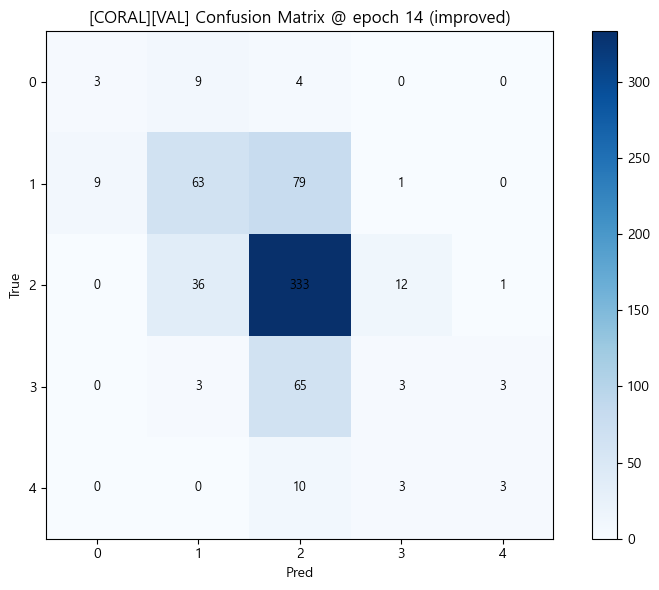

[CORAL] ep=014/100 | train_loss=0.0046 train_acc=0.9941 | val_loss=0.6583 val_acc=0.6328 | best=0.6328@014 | pat=00/10 | time=35.6s ★
[CORAL] ep=015/100 | train_loss=0.0041 train_acc=0.9956 | val_loss=0.6652 val_acc=0.6312 | best=0.6328@014 | pat=01/10 | time=35.0s
[CORAL] ep=016/100 | train_loss=0.0023 train_acc=0.9972 | val_loss=0.6882 val_acc=0.6156 | best=0.6328@014 | pat=02/10 | time=35.5s
[CORAL] ep=017/100 | train_loss=0.0034 train_acc=0.9965 | val_loss=0.7073 val_acc=0.6234 | best=0.6328@014 | pat=03/10 | time=37.1s
[CORAL] ep=018/100 | train_loss=0.0025 train_acc=0.9969 | val_loss=0.6959 val_acc=0.6094 | best=0.6328@014 | pat=04/10 | time=37.3s
[CORAL] ep=019/100 | train_loss=0.0018 train_acc=0.9982 | val_loss=0.6686 val_acc=0.6062 | best=0.6328@014 | pat=05/10 | time=35.4s
[CORAL] ep=020/100 | train_loss=0.0016 train_acc=0.9981 | val_loss=0.6594 val_acc=0.5984 | best=0.6328@014 | pat=06/10 | time=34.8s
[CORAL] ep=021/100 | train_loss=0.0017 train_acc=0.9979 | val_loss=0.6576 

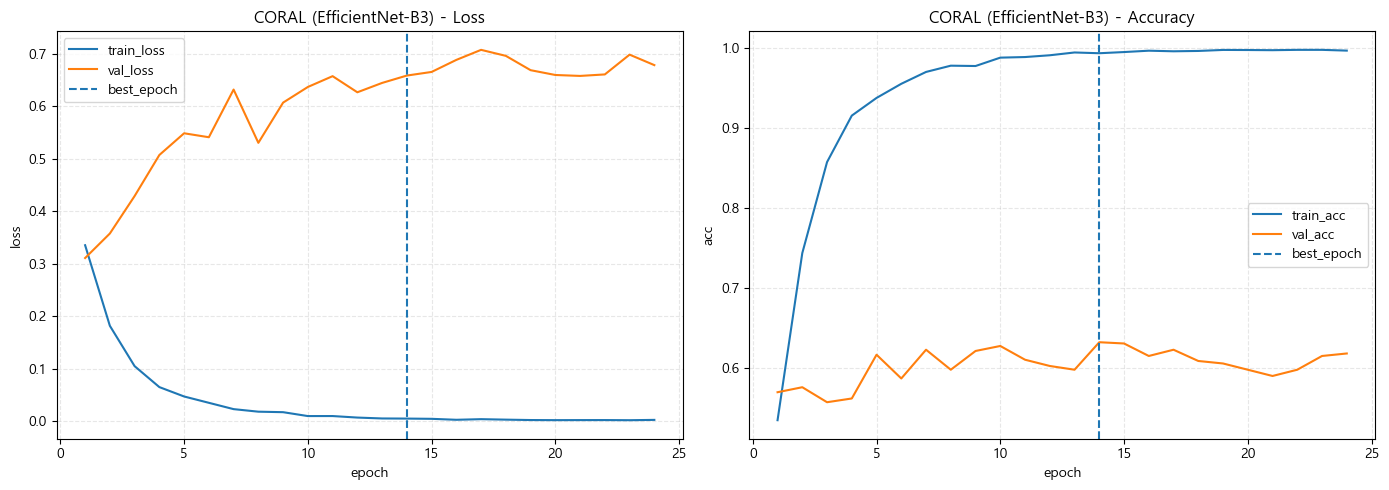


[CORAL][TEST] loss=0.9028 | acc=0.5891  ✅(정확도 출력)


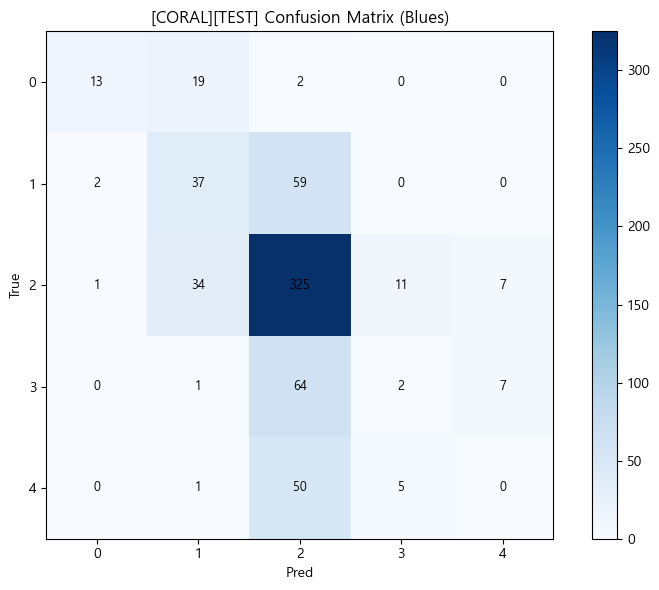

In [27]:
# ============================================================
# [CELL 6] 실행부: CORAL (요구사항 1~5 충족)
# - CORAL: 기본 학습 + (개선될 때마다 혼동행렬) + 러닝커브 + 테스트/혼동행렬
# ============================================================

# ----------------------------
# B) CORAL 실행 (요구사항 5: 개선될 때마다 혼동행렬)
# ----------------------------
coral_model, coral_hist, coral_ckpt = train_with_earlystop(
    mode="coral",
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    lr=LR, wd=WEIGHT_DECAY,
    tmax=T_MAX,
    grad_clip=GRAD_CLIP,
    amp=AMP,
    ckpt_name="best_effb3_coral_pore.pt",
    show_cm_on_improve=True,    # ✅ 요구사항: CORAL은 개선될 때마다 혼동행렬 표시
)

plot_learning_curves(coral_hist, title="CORAL (EfficientNet-B3)")

_ = test_and_report("coral", coral_ckpt, test_loader, title_prefix="")

## Version 2

### 전처리

In [32]:
# ============================================================
# [CELL 0] BUILD DATALOADERS ✅ (AUG -> TRAIN/VAL/TEST 모두 포함)  ✅ FINAL
# - Folder(피사체) 단위 split (누수 방지)  : split은 CROP 기준
# - AUG는 split 폴더에 맞춰 train/val/test 각각에 포함
# - num_workers=0
# - 분포 + aug 비율까지 출력
# ============================================================

import os, re, random
from glob import glob
from collections import defaultdict, Counter

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# -----------------------
# PATH
# -----------------------
VERSION  = "03"
WORK_DIR = r"D:\PyProject\AIFFEL_AI\skin_analysis"

CROP_LEFT  = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}")
CROP_RIGHT = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}")
AUG_LEFT   = os.path.join(WORK_DIR, f"crop_subject_LEFTcheek_pore_v{VERSION}_AUG")
AUG_RIGHT  = os.path.join(WORK_DIR, f"crop_subject_RIGHTcheek_pore_v{VERSION}_AUG")

# -----------------------
# filename parse
# -----------------------
# ...\0001\0001_03_angle0_F_LEFTcheek_pore2_crop.jpg
# ...\0001\0001_03_angle0_F_LEFTcheek_pore2_aug000.jpg
pat = re.compile(r"(?P<folder>\d{4})_.*_pore(?P<y>[0-4])_(?P<tag>crop|aug\d{3})\.jpg$", re.IGNORECASE)

def scan_items(root_dir):
    files = glob(os.path.join(root_dir, "*", "*.jpg")) if os.path.isdir(root_dir) else []
    items = []
    bad = 0
    for p in files:
        base = os.path.basename(p)
        m = pat.match(base)
        if not m:
            bad += 1
            continue
        items.append({
            "path": p,
            "folder": m.group("folder"),
            "y": int(m.group("y")),
            "is_aug": m.group("tag").lower().startswith("aug"),
        })
    # 혹시 path 중복 방지
    uniq = {}
    for it in items:
        uniq[it["path"]] = it
    items = list(uniq.values())
    return items, len(files), bad

# -----------------------
# scan
# -----------------------
crop_left,  n1, b1 = scan_items(CROP_LEFT)
crop_right, n2, b2 = scan_items(CROP_RIGHT)
aug_left,   n3, b3 = scan_items(AUG_LEFT)
aug_right,  n4, b4 = scan_items(AUG_RIGHT)

crop_items = crop_left + crop_right
aug_items  = aug_left  + aug_right

print("=== SCAN ===")
print(f"CROP_LEFT : files={n1}, parsed={len(crop_left)}, bad={b1}")
print(f"CROP_RIGHT: files={n2}, parsed={len(crop_right)}, bad={b2}")
print(f"AUG_LEFT  : files={n3}, parsed={len(aug_left)}, bad={b3}")
print(f"AUG_RIGHT : files={n4}, parsed={len(aug_right)}, bad={b4}")
print(f"TOTAL CROP items={len(crop_items)} | TOTAL AUG items={len(aug_items)}")

if len(crop_items) == 0:
    raise RuntimeError("CROP 데이터가 0개입니다. crop 폴더 경로/파일을 확인하세요.")
if len(aug_items) == 0:
    raise RuntimeError("AUG 데이터가 0개입니다. 증강 폴더 경로/파일명 규칙을 확인하세요.")

# -----------------------
# folder-group split (CROP만으로 폴더 나눔)
# -----------------------
def split_folders_by_crop(crop_items, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)

    folder2items = defaultdict(list)
    for it in crop_items:
        folder2items[it["folder"]].append(it)

    folders = sorted(folder2items.keys())
    random.shuffle(folders)

    n = len(folders)
    n_test = max(1, int(n * test_ratio))
    n_val  = max(1, int(n * val_ratio))

    test_folders = set(folders[:n_test])
    val_folders  = set(folders[n_test:n_test+n_val])
    train_folders= set(folders[n_test+n_val:])

    train_crop = [it for f in train_folders for it in folder2items[f]]
    val_crop   = [it for f in val_folders  for it in folder2items[f]]
    test_crop  = [it for f in test_folders for it in folder2items[f]]

    return train_folders, val_folders, test_folders, train_crop, val_crop, test_crop, set(folders)

train_folders, val_folders, test_folders, train_crop, val_crop, test_crop, crop_folder_set = split_folders_by_crop(
    crop_items, val_ratio=0.15, test_ratio=0.15, seed=42
)

# -----------------------
# ✅ AUG를 split 폴더에 맞춰 각각 합침
# - 단, "CROP에 존재하는 folder"만 인정 (폴더 불일치/누수 방지)
# -----------------------
aug_items_in_crop_folders = [it for it in aug_items if it["folder"] in crop_folder_set]

aug_train = [it for it in aug_items_in_crop_folders if it["folder"] in train_folders]
aug_val   = [it for it in aug_items_in_crop_folders if it["folder"] in val_folders]
aug_test  = [it for it in aug_items_in_crop_folders if it["folder"] in test_folders]

train_items = train_crop + aug_train
val_items   = val_crop   + aug_val
test_items  = test_crop  + aug_test

print("\n=== SPLIT ===")
print(f"folders: train={len(train_folders)}, val={len(val_folders)}, test={len(test_folders)}")
print(f"items  : train_crop={len(train_crop)}, aug_train={len(aug_train)} => train_total={len(train_items)}")
print(f"         val_crop={len(val_crop)},   aug_val={len(aug_val)}   => val_total={len(val_items)}")
print(f"         test_crop={len(test_crop)}, aug_test={len(aug_test)} => test_total={len(test_items)}")

def dist(items):
    c = Counter([it["y"] for it in items])
    tot = sum(c.values())
    aug = sum([1 for it in items if it.get("is_aug", False)])
    aug_pct = (aug / tot * 100) if tot else 0.0
    out = {k: f"{v} ({(v/tot*100 if tot else 0):.1f}%)" for k, v in sorted(c.items())}
    return out, f"{aug}/{tot} ({aug_pct:.1f}%)"

train_dist, train_auginfo = dist(train_items)
val_dist,   val_auginfo   = dist(val_items)
test_dist,  test_auginfo  = dist(test_items)

print("\n[DIST] train_total (CROP+AUG):", train_dist, "| aug:", train_auginfo)
print("[DIST] val_total   (CROP+AUG):", val_dist,   "| aug:", val_auginfo)
print("[DIST] test_total  (CROP+AUG):", test_dist,  "| aug:", test_auginfo)

# -----------------------
# Dataset / DataLoader
# -----------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class PoreDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        p = it["path"]
        y = it["y"]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

train_ds = PoreDataset(train_items, transform)
val_ds   = PoreDataset(val_items,   transform)
test_ds  = PoreDataset(test_items,  transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print("\n✅ DONE: train_loader / val_loader / test_loader ready (num_workers=0)")

=== SCAN ===
CROP_LEFT : files=2144, parsed=2144, bad=0
CROP_RIGHT: files=2144, parsed=2144, bad=0
AUG_LEFT  : files=4786, parsed=4786, bad=0
AUG_RIGHT : files=4798, parsed=4798, bad=0
TOTAL CROP items=4288 | TOTAL AUG items=9584

=== SPLIT ===
folders: train=752, val=160, test=160
items  : train_crop=3008, aug_train=6444 => train_total=9452
         val_crop=640,   aug_val=1264   => val_total=1904
         test_crop=640, aug_test=1876 => test_total=2516

[DIST] train_total (CROP+AUG): {0: '1488 (15.7%)', 1: '1992 (21.1%)', 2: '1832 (19.4%)', 3: '2020 (21.4%)', 4: '2120 (22.4%)'} | aug: 6444/9452 (68.2%)
[DIST] val_total   (CROP+AUG): {0: '384 (20.2%)', 1: '608 (31.9%)', 2: '382 (20.1%)', 3: '370 (19.4%)', 4: '160 (8.4%)'} | aug: 1264/1904 (66.4%)
[DIST] test_total  (CROP+AUG): {0: '816 (32.4%)', 1: '392 (15.6%)', 2: '378 (15.0%)', 3: '370 (14.7%)', 4: '560 (22.3%)'} | aug: 1876/2516 (74.6%)

✅ DONE: train_loader / val_loader / test_loader ready (num_workers=0)


### 2. 학습

In [37]:
# ============================================================
# [CELL 1] 공통 유틸: seed / 러닝커브 / 혼동행렬(Blue) / 평가 함수  ✅ FINAL
# - eval_loop: CE/CORAL 공용 + (선택) aug 비율/aug 포함여부 출력
# - 러닝커브: best_epoch(1-based) 기준 세로선
# - 혼동행렬: Blue + (선택) normalize=True 지원
# ============================================================

import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# -----------------------------
# 0) seed
# -----------------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# -----------------------------
# 1) (선택) dataset의 aug 비율 확인 유틸
#   - CELL0에서 items에 is_aug를 넣었기 때문에 사용 가능
# -----------------------------
def count_aug_from_loader(loader):
    try:
        items = loader.dataset.items
        n = len(items)
        n_aug = sum(1 for it in items if it.get("is_aug", False))
        return n_aug, n, (n_aug / n * 100 if n else 0.0)
    except Exception:
        return None, None, None

# -----------------------------
# 2) eval loop (CE / CORAL 공용)
# -----------------------------
@torch.no_grad()
def eval_loop(model, loader, mode="ce", print_aug_info=False, tag=""):
    """
    mode='ce'    : model(x) -> (B, K)
    mode='coral' : model(x) -> (B, K-1)
    return: loss_avg, acc_avg, y_true(list), y_pred(list)
    """
    if print_aug_info:
        n_aug, n_all, pct = count_aug_from_loader(loader)
        if n_aug is not None:
            print(f"[AUG CHECK]{' '+tag if tag else ''} aug={n_aug}/{n_all} ({pct:.1f}%)")
        else:
            print(f"[AUG CHECK]{' '+tag if tag else ''} (dataset.items 접근 불가)")

    model.eval()
    total_loss, total_correct, n = 0.0, 0.0, 0
    y_true_all, y_pred_all = [], []

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)

        if mode == "ce":
            # CE loss
            loss = F.cross_entropy(out, y, label_smoothing=LABEL_SMOOTH)
            pred = out.argmax(dim=1)

        elif mode == "coral":
            # CORAL loss/pred
            logits = out  # (B, K-1)
            ord_y  = labels_to_ordinal(y, NUM_CLASSES)  # (B, K-1)
            loss = F.binary_cross_entropy_with_logits(logits, ord_y)
            pred = coral_predict(logits)  # (B,)
        else:
            raise ValueError("mode must be 'ce' or 'coral'")

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_correct += (pred == y).float().sum().item()
        n += bs

        y_true_all.extend(y.detach().cpu().numpy().tolist())
        y_pred_all.extend(pred.detach().cpu().numpy().tolist())

    return total_loss / n, total_correct / n, y_true_all, y_pred_all

# -----------------------------
# 3) learning curves
# -----------------------------
def plot_learning_curves(history, title="Learning Curves"):
    """
    history keys:
      - train_loss, val_loss, train_acc, val_acc
      - best_epoch: 1-based epoch index (예: epoch=5가 best면 5)
    """
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    if history.get("best_epoch", None) is not None and history["best_epoch"] > 0:
        plt.axvline(history["best_epoch"], linestyle="--", label=f"best_epoch={history['best_epoch']}")
    plt.title(f"{title} - Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    # Acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    if history.get("best_epoch", None) is not None and history["best_epoch"] > 0:
        plt.axvline(history["best_epoch"], linestyle="--", label=f"best_epoch={history['best_epoch']}")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Confusion Matrix (Blue)
# -----------------------------
def plot_confmat_blue(
    y_true, y_pred,
    title="Confusion Matrix (Blue)",
    class_names=None,
    normalize=False
):
    """
    normalize=False: raw count
    normalize=True : row-normalized (%)
    return: cm, acc
    """
    labels = list(range(NUM_CLASSES))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if normalize:
        cm_show = cm.astype(np.float32)
        row_sum = cm_show.sum(axis=1, keepdims=True)
        cm_show = np.divide(cm_show, row_sum, out=np.zeros_like(cm_show), where=row_sum != 0) * 100.0
    else:
        cm_show = cm

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_show, cmap="Blues")
    plt.title(title + (" (norm%)" if normalize else ""))
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.colorbar()

    if class_names is None:
        class_names = [str(i) for i in range(NUM_CLASSES)]
    plt.xticks(range(NUM_CLASSES), class_names)
    plt.yticks(range(NUM_CLASSES), class_names)

    # 숫자 표기
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if normalize:
                txt = f"{cm_show[i, j]:.1f}"
            else:
                txt = str(cm_show[i, j])
            plt.text(j, i, txt, ha="center", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return cm, acc

In [39]:
# ============================================================
# [CELL 2] 모델 정의 (공통 backbone) + CORAL 유틸  ✅ FINAL
# - 기본 골격 유지 (CE head / CORAL head)
# - (안전) backbone 출력 shape 대응(flatten)
# - (선택) freeze_backbone 옵션(기본 False = 기존과 동일)
# ============================================================

# ---------- CORAL utilities ----------
def labels_to_ordinal(y, num_classes=NUM_CLASSES):
    """
    y: (B,) in 0..K-1
    return: (B, K-1) with 1 if y>=k else 0 for k=1..K-1
    """
    B = y.size(0)
    K = num_classes
    th = torch.arange(1, K, device=y.device).view(1, K-1).repeat(B, 1)   # 1..K-1
    y_expand = y.view(B, 1).repeat(1, K-1)
    return (y_expand >= th).float()

@torch.no_grad()
def coral_predict(logits):
    p = torch.sigmoid(logits)
    return (p > 0.5).sum(dim=1).long()

# ---------- Backbones ----------
class EffB3_CE(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dropout=DROPOUT, freeze_backbone=False):
        super().__init__()
        w = EfficientNet_B3_Weights.DEFAULT
        self.backbone = models.efficientnet_b3(weights=w)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # (선택) backbone freeze
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)                 # usually (B, C) but 안전하게 처리
        if feat.ndim > 2:
            feat = torch.flatten(feat, 1)      # (B, C, 1, 1) -> (B, C)
        return self.head(feat)


class EffB3_CORAL(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dropout=DROPOUT, freeze_backbone=False):
        super().__init__()
        w = EfficientNet_B3_Weights.DEFAULT
        self.backbone = models.efficientnet_b3(weights=w)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # (선택) backbone freeze
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # K-1 thresholds
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes - 1)
        )

    def forward(self, x):
        feat = self.backbone(x)
        if feat.ndim > 2:
            feat = torch.flatten(feat, 1)
        return self.head(feat)

In [41]:
# ============================================================
# [CELL 3] 학습 루프 (조기종료/페이션스/정칙화/러닝커브/조건 추적) ✅ FINAL
# - 기본 골격 유지
# - (필수) AMP: CUDA일 때만 활성화 (CPU에서도 안전)
# - (선택) best ckpt에 val_acc 같이 저장
# ============================================================

def train_with_earlystop(
    mode,                         # "ce" or "coral"
    train_loader, val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    lr=LR, wd=WEIGHT_DECAY,
    tmax=T_MAX,
    grad_clip=GRAD_CLIP,
    amp=AMP,
    ckpt_name="best.pt",
    # ✅ CORAL 요구: 개선될 때마다 혼동행렬 보여주기
    show_cm_on_improve=False,
):
    assert mode in ("ce", "coral")

    # ✅ AMP는 CUDA에서만 켜기 (안전)
    amp = bool(amp) and str(DEVICE).startswith("cuda")

    # model
    model = EffB3_CE().to(DEVICE) if mode == "ce" else EffB3_CORAL().to(DEVICE)

    # optimizer / scheduler
    opt = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sch = CosineAnnealingLR(opt, T_max=tmax, eta_min=1e-6)

    # ✅ GradScaler도 amp 조건에 맞춰서
    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    # history for learning curves
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "best_epoch": 0,
        "best_val_acc": -1.0,
        "early_stop_counter_trace": [],
    }

    best_path = os.path.join(SAVE_DIR, ckpt_name)
    early_counter = 0

    print("\n" + "="*90)
    print(f"[TRAIN START] mode={mode.upper()} | epochs={epochs} | patience={patience} | lr={lr} | wd={wd} | amp={amp} | grad_clip={grad_clip}")
    print(f"[SAVE] {best_path}")
    print("="*90)

    for ep in range(1, epochs + 1):
        t0 = time.time()
        model.train()

        total_loss, total_correct, n = 0.0, 0.0, 0

        for x, y in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)

            # ✅ autocast: CUDA일 때만
            with torch.cuda.amp.autocast(enabled=amp):
                out = model(x)

                if mode == "ce":
                    loss = F.cross_entropy(out, y, label_smoothing=LABEL_SMOOTH)
                    pred = out.argmax(dim=1)

                else:  # coral
                    logits = out
                    ord_y  = labels_to_ordinal(y, NUM_CLASSES)
                    loss = F.binary_cross_entropy_with_logits(logits, ord_y)
                    pred = coral_predict(logits)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(opt)
            scaler.update()

            bs = y.size(0)
            total_loss += loss.item() * bs
            total_correct += (pred == y).float().sum().item()
            n += bs

        sch.step()

        train_loss = total_loss / n
        train_acc  = total_correct / n

        val_loss, val_acc, yv_true, yv_pred = eval_loop(model, val_loader, mode=mode)

        # --- early stopping logic (val_acc 기준) ---
        improved = val_acc > history["best_val_acc"]
        if improved:
            history["best_val_acc"] = val_acc
            history["best_epoch"] = ep
            early_counter = 0

            # ✅ best 저장에 val_acc 같이 저장 (재현/추적용)
            torch.save(
                {
                    "epoch": ep,
                    "mode": mode,
                    "val_acc": float(val_acc),
                    "state_dict": model.state_dict(),
                },
                best_path
            )

            # ✅ 개선 시 혼동행렬
            if show_cm_on_improve:
                _cm, _acc = plot_confmat_blue(
                    yv_true, yv_pred,
                    title=f"[{mode.upper()}][VAL] Confusion Matrix @ epoch {ep} (improved)",
                    class_names=[f"{i}" for i in range(NUM_CLASSES)]
                )
        else:
            early_counter += 1

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["early_stop_counter_trace"].append(early_counter)

        dt = time.time() - t0

        # epoch마다 early_stop 상태 출력
        print(
            f"[{mode.upper()}] ep={ep:03d}/{epochs} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
            f"best={history['best_val_acc']:.4f}@{history['best_epoch']:03d} | "
            f"pat={early_counter:02d}/{patience} | "
            f"time={dt:.1f}s"
            + (" ★" if improved else "")
        )

        if early_counter >= patience:
            print(f"\n[EARLY STOP] no improvement for {patience} epochs. stop at ep={ep}.")
            break

    print("\n" + "-"*90)
    print(f"[TRAIN END] best_val_acc={history['best_val_acc']:.4f} | best_epoch={history['best_epoch']}")
    print(f"[CKPT] {best_path}")
    print("-"*90)

    return model, history, best_path

In [43]:
# ============================================================
# [CELL 4] 테스트(별도) + 혼동행렬(Blue) + 정확도 출력 (요구사항 4) ✅ FINAL
# - ckpt 포맷 안전 로드(state_dict 키 체크)
# - 혼동행렬 acc와 eval_loop acc를 같이 출력(검산)
# ============================================================

@torch.no_grad()
def test_and_report(mode, ckpt_path, test_loader, title_prefix=""):
    assert mode in ("ce", "coral")

    # model load
    model = EffB3_CE().to(DEVICE) if mode == "ce" else EffB3_CORAL().to(DEVICE)

    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    # ✅ ckpt 저장 포맷 안전 처리
    state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
    model.load_state_dict(state_dict, strict=True)

    model.eval()

    test_loss, test_acc, yt_true, yt_pred = eval_loop(model, test_loader, mode=mode)

    print("\n" + "="*90)
    print(f"[{mode.upper()}][TEST] loss={test_loss:.4f} | acc={test_acc:.4f}  ✅(정확도 출력)")
    print("="*90)

    # confusion matrix (blue) + acc(검산)
    prefix = (title_prefix + " ") if (title_prefix and not title_prefix.endswith(" ")) else title_prefix
    cm, acc_cm = plot_confmat_blue(
        yt_true, yt_pred,
        title=f"{prefix}[{mode.upper()}][TEST] Confusion Matrix (Blues)",
        class_names=[f"{i}" for i in range(NUM_CLASSES)]
    )

    print(f"[{mode.upper()}][TEST] acc(from CM)={acc_cm:.4f} (검산용)")

    return test_loss, test_acc


[TRAIN START] mode=CE | epochs=100 | patience=10 | lr=0.0003 | wd=0.0003 | amp=True | grad_clip=1.0
[SAVE] ./checkpoints_pore\best_effb3_ce_pore.pt
[CE] ep=001/100 | train_loss=0.9725 train_acc=0.5851 | val_loss=1.4779 val_acc=0.4790 | best=0.4790@001 | pat=00/10 | time=37.8s ★
[CE] ep=002/100 | train_loss=0.5433 train_acc=0.7836 | val_loss=1.7048 val_acc=0.5100 | best=0.5100@002 | pat=00/10 | time=38.0s ★
[CE] ep=003/100 | train_loss=0.3037 train_acc=0.8888 | val_loss=2.1865 val_acc=0.4968 | best=0.5100@002 | pat=01/10 | time=36.7s
[CE] ep=004/100 | train_loss=0.1852 train_acc=0.9337 | val_loss=2.3319 val_acc=0.5042 | best=0.5100@002 | pat=02/10 | time=36.9s
[CE] ep=005/100 | train_loss=0.1399 train_acc=0.9519 | val_loss=2.8742 val_acc=0.4916 | best=0.5100@002 | pat=03/10 | time=36.1s
[CE] ep=006/100 | train_loss=0.1057 train_acc=0.9629 | val_loss=2.7486 val_acc=0.5011 | best=0.5100@002 | pat=04/10 | time=36.6s
[CE] ep=007/100 | train_loss=0.0796 train_acc=0.9722 | val_loss=3.0886 va

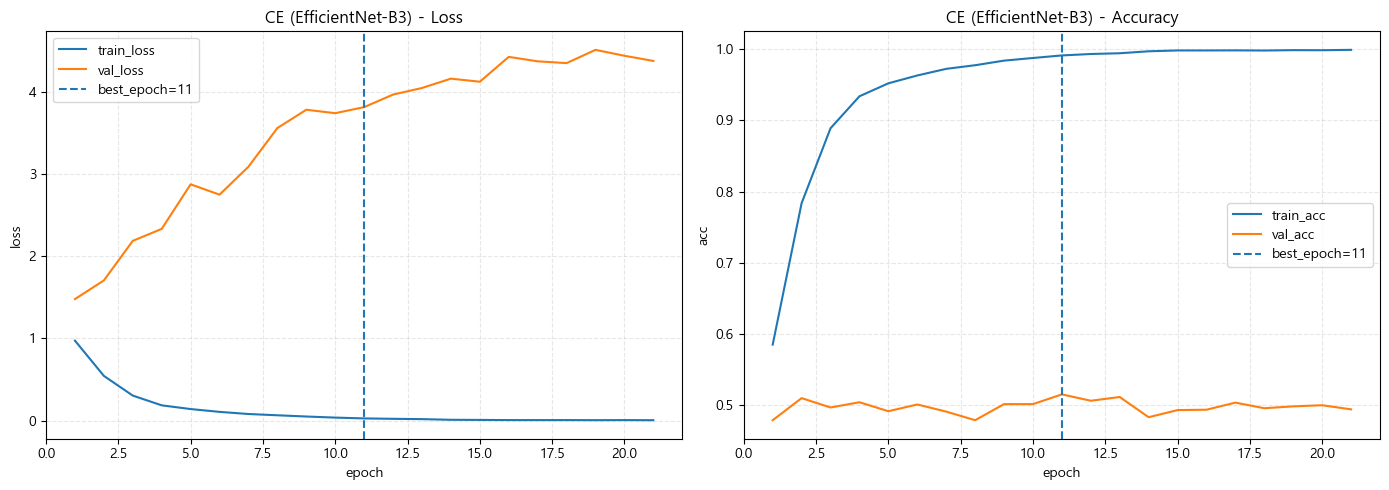


[CE][TEST] loss=3.7126 | acc=0.5338  ✅(정확도 출력)


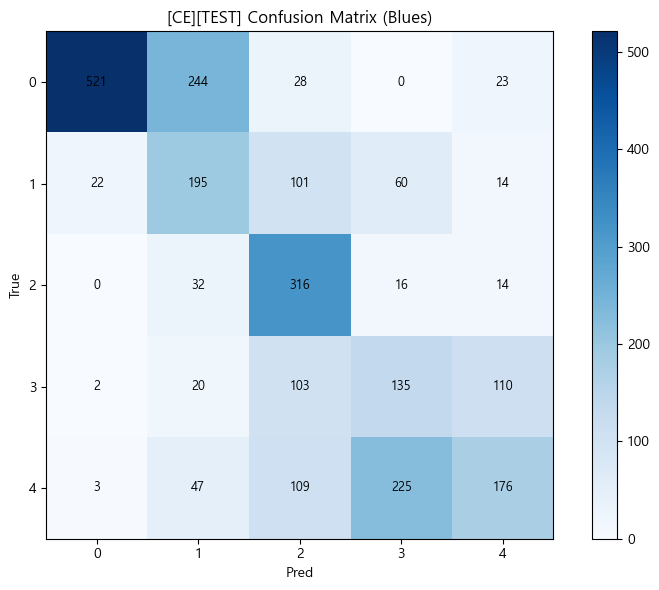

[CE][TEST] acc(from CM)=0.5338 (검산용)
[CE][FINAL] test_loss=3.7126 | test_acc=0.5338


In [45]:
# ============================================================
# [CELL 5] 실행부: CE (요구사항 1~5 충족)
# - CE: 기본 학습 + 러닝커브 + 테스트/혼동행렬
# ============================================================

# ✅ (권장) 실행부에서도 시드 고정 (셀 실행 순서 꼬임 방지)
seed_everything(42)

# ----------------------------
# A) CE 실행
# ----------------------------
ce_model, ce_hist, ce_ckpt = train_with_earlystop(
    mode="ce",
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    lr=LR, wd=WEIGHT_DECAY,
    tmax=T_MAX,
    grad_clip=GRAD_CLIP,
    amp=AMP,
    ckpt_name="best_effb3_ce_pore.pt",
    show_cm_on_improve=False,   # (선택) True로 켜면 CE도 개선마다 VAL 혼동행렬 출력 가능
)

print(f"\n[CE] best ckpt saved to: {ce_ckpt} | best_epoch={ce_hist.get('best_epoch')} | best_val_acc={ce_hist.get('best_val_acc'):.4f}")

plot_learning_curves(ce_hist, title="CE (EfficientNet-B3)")

ce_test_loss, ce_test_acc = test_and_report("ce", ce_ckpt, test_loader, title_prefix="")
print(f"[CE][FINAL] test_loss={ce_test_loss:.4f} | test_acc={ce_test_acc:.4f}")


[TRAIN START] mode=CORAL | epochs=100 | patience=10 | lr=0.0003 | wd=0.0003 | amp=True | grad_clip=1.0
[SAVE] ./checkpoints_pore\best_effb3_coral_pore.pt


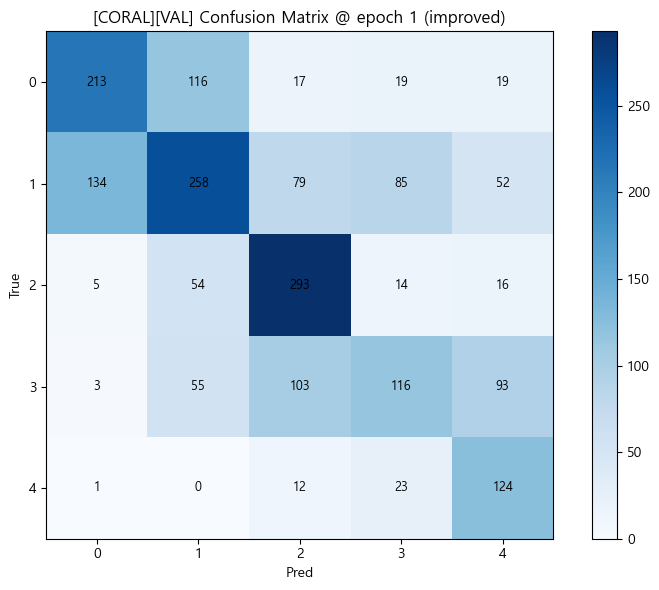

[CORAL] ep=001/100 | train_loss=0.3291 train_acc=0.5359 | val_loss=0.3925 val_acc=0.5273 | best=0.5273@001 | pat=00/10 | time=38.3s ★
[CORAL] ep=002/100 | train_loss=0.1857 train_acc=0.7396 | val_loss=0.4960 val_acc=0.5021 | best=0.5273@001 | pat=01/10 | time=37.1s
[CORAL] ep=003/100 | train_loss=0.1078 train_acc=0.8517 | val_loss=0.5905 val_acc=0.5053 | best=0.5273@001 | pat=02/10 | time=37.1s
[CORAL] ep=004/100 | train_loss=0.0678 train_acc=0.9122 | val_loss=0.7009 val_acc=0.4958 | best=0.5273@001 | pat=03/10 | time=37.2s
[CORAL] ep=005/100 | train_loss=0.0460 train_acc=0.9397 | val_loss=0.8156 val_acc=0.5168 | best=0.5273@001 | pat=04/10 | time=37.2s
[CORAL] ep=006/100 | train_loss=0.0326 train_acc=0.9563 | val_loss=0.8327 val_acc=0.5000 | best=0.5273@001 | pat=05/10 | time=36.8s
[CORAL] ep=007/100 | train_loss=0.0285 train_acc=0.9632 | val_loss=0.8067 val_acc=0.5100 | best=0.5273@001 | pat=06/10 | time=38.1s
[CORAL] ep=008/100 | train_loss=0.0184 train_acc=0.9761 | val_loss=1.0302 

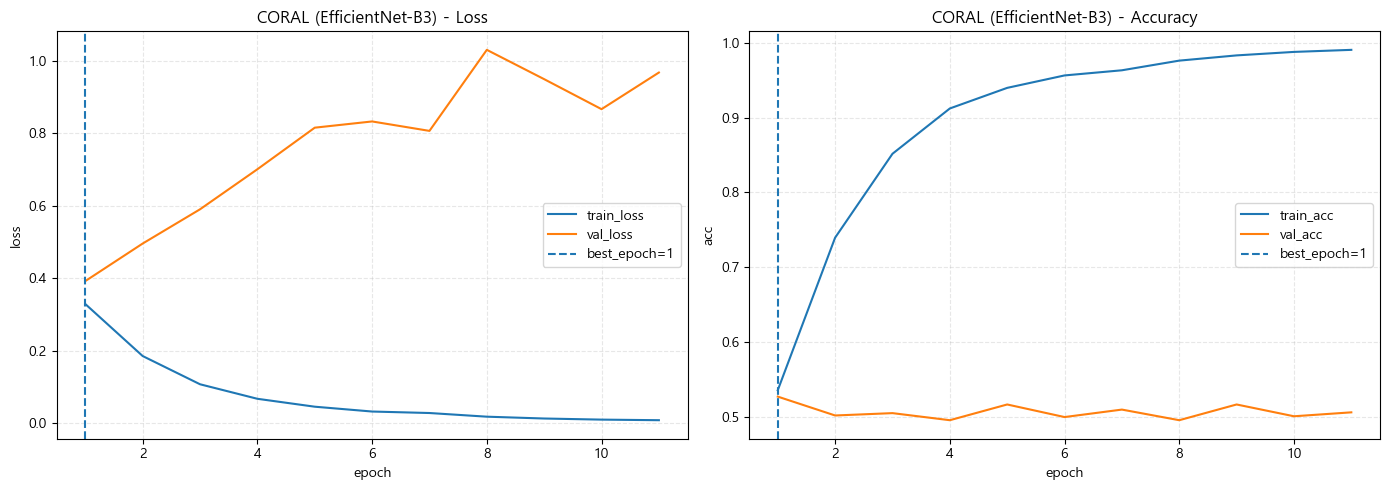


[CORAL][TEST] loss=0.3115 | acc=0.5711  ✅(정확도 출력)


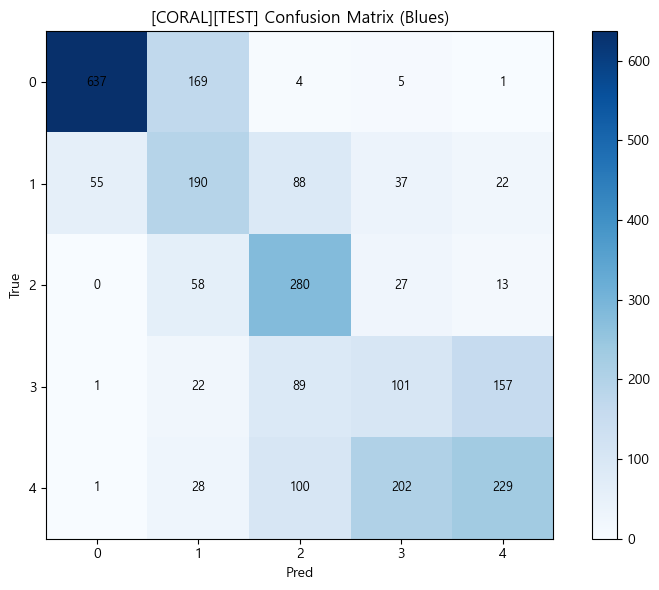

[CORAL][TEST] acc(from CM)=0.5711 (검산용)
[CORAL][FINAL] test_loss=0.3115 | test_acc=0.5711


In [48]:
# ============================================================
# [CELL 6] 실행부: CORAL (요구사항 1~5 충족)
# - CORAL: 기본 학습 + (개선될 때마다 혼동행렬) + 러닝커브 + 테스트/혼동행렬
# ============================================================

# ✅ (권장) 실행부에서도 시드 고정
seed_everything(42)

# ----------------------------
# B) CORAL 실행 (요구사항 5: 개선될 때마다 혼동행렬)
# ----------------------------
coral_model, coral_hist, coral_ckpt = train_with_earlystop(
    mode="coral",
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    patience=PATIENCE,
    lr=LR, wd=WEIGHT_DECAY,
    tmax=T_MAX,
    grad_clip=GRAD_CLIP,
    amp=AMP,
    ckpt_name="best_effb3_coral_pore.pt",
    show_cm_on_improve=True,    # ✅ 요구사항: CORAL은 개선될 때마다 혼동행렬 표시
)

print(f"\n[CORAL] best ckpt saved to: {coral_ckpt} | best_epoch={coral_hist.get('best_epoch')} | best_val_acc={coral_hist.get('best_val_acc'):.4f}")

plot_learning_curves(coral_hist, title="CORAL (EfficientNet-B3)")

coral_test_loss, coral_test_acc = test_and_report("coral", coral_ckpt, test_loader, title_prefix="")
print(f"[CORAL][FINAL] test_loss={coral_test_loss:.4f} | test_acc={coral_test_acc:.4f}")